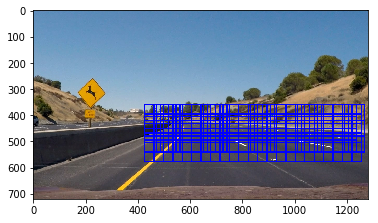

In [8]:
# Main file for the project
import glob
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

# Now to detect images, get the frame, iterate (windows) then check if there is a car in the box!
# test car detection on test images
from utilities import slide_window, draw_boxes
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
# Train network
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from utilities import draw_boxes, extract_features, add_heat, apply_threshold, draw_labeled_bboxes
from time import time
import PIL


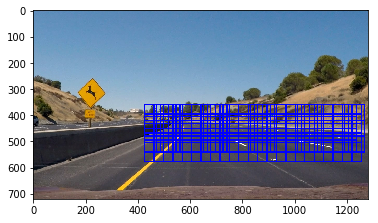

In [9]:

plt.interactive(False)
# Prepare data, first read images of cars and not cars, then extract features,
# the labels will just be a 1 for CAR and a 0 for "NOT CAR"

# Read images from dataset
# Small dataset
#img_cars_files = glob.glob("dataset\\vehicles_smallset\\**\\*.jpeg",recursive= True)
#img_notcars_files = glob.glob("dataset\\non-vehicles_smallset\\**\\*.jpeg",recursive= True)
# Large dataset
img_cars_files = glob.glob("dataset\\vehicles\\**\\*.png",recursive= True)
img_notcars_files = glob.glob("dataset\\non-vehicles\\**\\*.png",recursive= True)

img_cars = []
img_not_cars = []
for image_file in img_cars_files:
    img_cars.append(image_file)
for image_file in img_notcars_files:
    img_not_cars.append(image_file)

# Extract features from images of cars and not-cars
car_features = extract_features(img_cars)
notcar_features = extract_features(img_not_cars)

X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Create corresponding labels
y = np.hstack((np.ones(len(car_features)),
              np.zeros(len(notcar_features))))
n_classes = 2

## Split dataset into training and test set
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Scale features
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X_train and X_test
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

########## Use GridSearchCV to find good parameters for SV classifier #############
# Check the training time for the SVC
# GridSeachCV Is very slow, but I can use it to find the best parameters for SVC
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100], }
#parameters = [
#  {'C': [1, 10, 100], 'kernel': ['linear']},
#  {'C': [1, 10, 100], 'gamma': [0.001, 0.0001, 0.00001], 'degree': [2, 3, 4], 'kernel': ['rbf']},
# ]
#clf = GridSearchCV(svc, parameters, return_train_score=False, n_jobs=8)
#print("Best estimator found by grid search:")
#print(clf.best_estimator_)
###################################################################################

# Classifier with parameter set found via GridSearchCV
clf = svm.SVC(C=10, cache_size=1000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.005, verbose=False)

print("Fitting the classifier to the training set")
t0 = time()
clf.fit(scaled_X_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting...")
t0 = time()
y_pred = clf.predict(scaled_X_test)
print("done in %0.3fs" % (time() - t0))

print("Classification report")
print(classification_report(y_test, y_pred, target_names=['Car','Not Car']))

print("Confusion matrix")
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


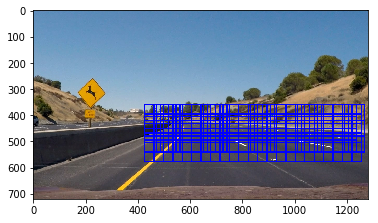

In [11]:
def detect_cars(frame):
    detected_windows = []
    # Classification step
    X_show = True
    for window in windows:
        cropped_fig = frame[window[0][1]:window[1][1], window[0][0]:window[1][0]]
        # need to resize to a 64 by 64 image to classify
        dst = cv2.resize(cropped_fig, (64, 64), interpolation=cv2.INTER_NEAREST)
        # Classify
        #X = extract_features(dst,
        #                     c_space='YUV',
        #                     spatial_size=(32, 32),
        #                     hist_bins=32,
        #                     hist_range=(0, 256),
        #                     hog_channels='ALL',
        #                     hog_orient=11,
        #                     hog_pix_per_cell=16,
        #                     hog_cell_per_block=2)
        X = extract_features(dst,
                             c_space='YUV',
                             spatial_size=(32, 32),
                             hist_bins=32,
                             hist_range=(0, 256),
                             hog_channels=2,
                             hog_orient=8,
                             hog_pix_per_cell=8,
                             hog_cell_per_block=2)
        # Apply the scaler to X_train and X_test
        scaled_X = X_scaler.transform([np.array(X)])
        Y_pred = clf.predict(scaled_X)
        if X_show:
            #print("Mean Std X: {}, {}".format(np.mean(X), np.std(X)))
            #print("Scald MS X: {}, {}".format(np.mean(scaled_X), np.std(scaled_X)))
            X_show = False
        if Y_pred:
            detected_windows.append(window)
            # cv2.rectangle(frame, (window[0][0],window[1][0]),(window[0][1],window[1][1]), (0, 0, 255), 6)

    heat = np.zeros_like(frame[:, :, 0]).astype(np.float)
    # Add heat to each box in box list
    heatmap = add_heat(heat, detected_windows)

    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heatmap, threshold=1)

    # Clip heatmap
    heatmap = np.clip(heatmap, 0, 255)
    #print(np.amin(heatmap))
    #print(np.amax(heatmap))
    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    draw_img = draw_labeled_bboxes(np.copy(frame), labels)

    heatmap *= 255
    heatmap = np.uint8(np.clip(heatmap, 0, 255))

    # Add heatmap to frame (top left corner)
    img_w, img_h = (320, 240)
    bg_w, bg_h = (1280, 720)
    offset = ((bg_w - img_w) // 8, (bg_h - img_h) // 8)
    heatmap_small = cv2.resize(heatmap, (320, 240))
    heatmap_small_pip = PIL.Image.fromarray(heatmap_small)

    draw_img_pip = PIL.Image.fromarray(draw_img)
    draw_img_pip.paste(heatmap_small_pip, offset)
    draw_img_return = np.array(draw_img_pip)
    # draw_img = draw_boxes(frame, detected_windows, thickness=3)
    return draw_img_return

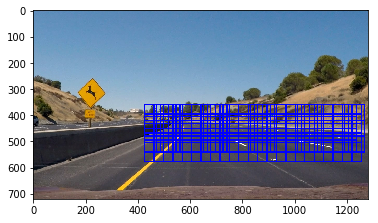

In [17]:
# Define windows where to search

test_image = mpimg.imread("test_images\\test2.jpg")
img = np.zeros_like(test_image,dtype= np.uint8)
windows = slide_window(img,
                       (int(test_image.shape[1]*1/3), test_image.shape[1]),
                       (int(test_image.shape[0] / 2), int(test_image.shape[0]*8/10)),
                       xy_window=(int(test_image.shape[0] / 4), int(test_image.shape[0] / 4)))

for den in [6, 8, 10]:
    windows += slide_window(test_image,
                            (int(test_image.shape[1]*1/3), test_image.shape[1]),
                            (int(test_image.shape[0] / 2), int(test_image.shape[0]*8/10)),
                            xy_window=(int(test_image.shape[0] / den), int(test_image.shape[0] / den)))

# Explore data
imcopy = draw_boxes(test_image, windows, thickness=3)
plt.figure()
plt.imshow(imcopy)
plt.savefig("windows.png")
plt.show()



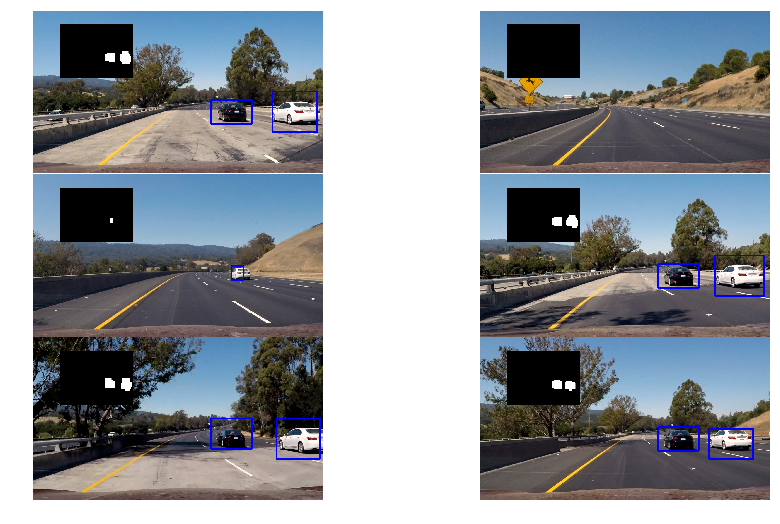

In [18]:
# Test algorithm on test images

test_images = glob.glob('./test_images/test*.jpg')
plt.interactive(False)
fig, axs = plt.subplots(3, 2, figsize=(16,9))
fig.subplots_adjust(hspace = .004, wspace=.004)
axs = axs.ravel()

for i, im in enumerate(test_images[0:6]):
    axs[i].imshow(detect_cars(mpimg.imread(im)))
    axs[i].axis('off')
plt.savefig("processed_test_images.png")
plt.show()


In [19]:
# Generate video output
from time import strftime
timestr = strftime("%Y%m%d-%H%M%S")
print("Generating video output!")
project_video_output = 'project_video_out-' + timestr + '.mp4'
clip = VideoFileClip('project_video3.mp4')
out_clip = clip.fl_image(detect_cars)
print("Writing video output to file...")
out_clip.write_videofile(project_video_output, audio=False)
print("Done")
import os
os.startfile(project_video_output)


Generating video output!

Writing video output to file...

[MoviePy] >>>> Building video project_video_out-20180520-194633.mp4


[MoviePy] Writing video project_video_out-20180520-194633.mp4


  0%|                                                    | 0/1261 [00:00<?, ?it/s]

  0%|                                          | 1/1261 [00:04<1:39:27,  4.74s/it]

  0%|                                          | 2/1261 [00:09<1:40:39,  4.80s/it]

  0%|                                          | 3/1261 [00:14<1:41:04,  4.82s/it]

  0%|▏                                         | 4/1261 [00:19<1:40:19,  4.79s/it]

  0%|▏                                         | 5/1261 [00:23<1:40:10,  4.79s/it]

  0%|▏                                         | 6/1261 [00:28<1:40:12,  4.79s/it]

  1%|▏                                         | 7/1261 [00:33<1:40:51,  4.83s/it]

  1%|▎                                         | 8/1261 [00:39<1:42:47,  4.92s/it]

  1%|▎                                         | 9/1261 [00:44<1:43:22,  4.95s/it]

  1%|▎                                        | 10/1261 [00:49<1:42:37,  4.92s/it]

  1%|▎                                        | 11/1261 [00:53<1:42:15,  4.91s/it]

  1%|▍                                        | 12/1261 [00:58<1:42:06,  4.90s/it]

  1%|▍                                        | 13/1261 [01:03<1:42:07,  4.91s/it]

  1%|▍                                        | 14/1261 [01:09<1:42:57,  4.95s/it]

  1%|▍                                        | 15/1261 [01:14<1:42:45,  4.95s/it]

  1%|▌                                        | 16/1261 [01:19<1:43:41,  5.00s/it]

  1%|▌                                        | 17/1261 [01:27<1:46:25,  5.13s/it]

  1%|▌                                        | 18/1261 [01:32<1:46:50,  5.16s/it]

  2%|▌                                        | 19/1261 [01:38<1:46:51,  5.16s/it]

  2%|▋                                        | 20/1261 [01:42<1:46:22,  5.14s/it]

  2%|▋                                        | 21/1261 [01:47<1:45:59,  5.13s/it]

  2%|▋                                        | 22/1261 [01:52<1:45:29,  5.11s/it]

  2%|▋                                        | 23/1261 [01:57<1:45:15,  5.10s/it]

  2%|▊                                        | 24/1261 [02:01<1:44:47,  5.08s/it]

  2%|▊                                        | 25/1261 [02:06<1:44:32,  5.07s/it]

  2%|▊                                        | 26/1261 [02:11<1:44:09,  5.06s/it]

  2%|▉                                        | 27/1261 [02:16<1:43:50,  5.05s/it]

  2%|▉                                        | 28/1261 [02:21<1:43:30,  5.04s/it]

  2%|▉                                        | 29/1261 [02:25<1:43:12,  5.03s/it]

  2%|▉                                        | 30/1261 [02:30<1:42:55,  5.02s/it]

  2%|█                                        | 31/1261 [02:35<1:42:39,  5.01s/it]

  3%|█                                        | 32/1261 [02:39<1:42:18,  4.99s/it]

  3%|█                                        | 33/1261 [02:44<1:42:04,  4.99s/it]

  3%|█                                        | 34/1261 [02:49<1:41:47,  4.98s/it]

  3%|█▏                                       | 35/1261 [02:54<1:41:35,  4.97s/it]

  3%|█▏                                       | 36/1261 [02:58<1:41:18,  4.96s/it]

  3%|█▏                                       | 37/1261 [03:03<1:41:06,  4.96s/it]

  3%|█▏                                       | 38/1261 [03:07<1:40:49,  4.95s/it]

  3%|█▎                                       | 39/1261 [03:12<1:40:37,  4.94s/it]

  3%|█▎                                       | 40/1261 [03:17<1:40:23,  4.93s/it]

  3%|█▎                                       | 41/1261 [03:22<1:40:13,  4.93s/it]

  3%|█▎                                       | 42/1261 [03:26<1:40:05,  4.93s/it]

  3%|█▍                                       | 43/1261 [03:31<1:39:56,  4.92s/it]

  3%|█▍                                       | 44/1261 [03:36<1:39:42,  4.92s/it]

  4%|█▍                                       | 45/1261 [03:41<1:39:33,  4.91s/it]

  4%|█▍                                       | 46/1261 [03:45<1:39:22,  4.91s/it]

  4%|█▌                                       | 47/1261 [03:50<1:39:12,  4.90s/it]

  4%|█▌                                       | 48/1261 [03:55<1:39:03,  4.90s/it]

  4%|█▌                                       | 49/1261 [03:59<1:38:55,  4.90s/it]

  4%|█▋                                       | 50/1261 [04:04<1:38:44,  4.89s/it]

  4%|█▋                                       | 51/1261 [04:09<1:38:37,  4.89s/it]

  4%|█▋                                       | 52/1261 [04:14<1:38:26,  4.89s/it]

  4%|█▋                                       | 53/1261 [04:18<1:38:18,  4.88s/it]

  4%|█▊                                       | 54/1261 [04:23<1:38:08,  4.88s/it]

  4%|█▊                                       | 55/1261 [04:28<1:38:00,  4.88s/it]

  4%|█▊                                       | 56/1261 [04:32<1:37:49,  4.87s/it]

  5%|█▊                                       | 57/1261 [04:37<1:37:41,  4.87s/it]

  5%|█▉                                       | 58/1261 [04:42<1:37:33,  4.87s/it]

  5%|█▉                                       | 59/1261 [04:46<1:37:26,  4.86s/it]

  5%|█▉                                       | 60/1261 [04:51<1:37:17,  4.86s/it]

  5%|█▉                                       | 61/1261 [04:56<1:37:10,  4.86s/it]

  5%|██                                       | 62/1261 [05:01<1:37:02,  4.86s/it]

  5%|██                                       | 63/1261 [05:05<1:36:55,  4.85s/it]

  5%|██                                       | 64/1261 [05:10<1:36:45,  4.85s/it]

  5%|██                                       | 65/1261 [05:15<1:36:38,  4.85s/it]

  5%|██▏                                      | 66/1261 [05:19<1:36:30,  4.85s/it]

  5%|██▏                                      | 67/1261 [05:24<1:36:23,  4.84s/it]

  5%|██▏                                      | 68/1261 [05:29<1:36:15,  4.84s/it]

  5%|██▏                                      | 69/1261 [05:33<1:36:09,  4.84s/it]

  6%|██▎                                      | 70/1261 [05:38<1:36:07,  4.84s/it]

  6%|██▎                                      | 71/1261 [05:43<1:36:02,  4.84s/it]

  6%|██▎                                      | 72/1261 [05:48<1:36:01,  4.85s/it]

  6%|██▎                                      | 73/1261 [05:53<1:35:55,  4.84s/it]

  6%|██▍                                      | 74/1261 [05:58<1:35:48,  4.84s/it]

  6%|██▍                                      | 75/1261 [06:03<1:35:42,  4.84s/it]

  6%|██▍                                      | 76/1261 [06:07<1:35:34,  4.84s/it]

  6%|██▌                                      | 77/1261 [06:12<1:35:28,  4.84s/it]

  6%|██▌                                      | 78/1261 [06:17<1:35:21,  4.84s/it]

  6%|██▌                                      | 79/1261 [06:21<1:35:15,  4.84s/it]

  6%|██▌                                      | 80/1261 [06:26<1:35:08,  4.83s/it]

  6%|██▋                                      | 81/1261 [06:31<1:35:02,  4.83s/it]

  7%|██▋                                      | 82/1261 [06:35<1:34:52,  4.83s/it]

  7%|██▋                                      | 83/1261 [06:40<1:34:47,  4.83s/it]

  7%|██▋                                      | 84/1261 [06:45<1:34:36,  4.82s/it]

  7%|██▊                                      | 85/1261 [06:49<1:34:27,  4.82s/it]

  7%|██▊                                      | 86/1261 [06:54<1:34:16,  4.81s/it]

  7%|██▊                                      | 87/1261 [06:58<1:34:07,  4.81s/it]

  7%|██▊                                      | 88/1261 [07:02<1:33:57,  4.81s/it]

  7%|██▉                                      | 89/1261 [07:07<1:33:47,  4.80s/it]

  7%|██▉                                      | 90/1261 [07:11<1:33:36,  4.80s/it]

  7%|██▉                                      | 91/1261 [07:16<1:33:27,  4.79s/it]

  7%|██▉                                      | 92/1261 [07:20<1:33:21,  4.79s/it]

  7%|███                                      | 93/1261 [07:25<1:33:16,  4.79s/it]

  7%|███                                      | 94/1261 [07:30<1:33:09,  4.79s/it]

  8%|███                                      | 95/1261 [07:35<1:33:05,  4.79s/it]

  8%|███                                      | 96/1261 [07:39<1:32:57,  4.79s/it]

  8%|███▏                                     | 97/1261 [07:44<1:32:52,  4.79s/it]

  8%|███▏                                     | 98/1261 [07:49<1:32:46,  4.79s/it]

  8%|███▏                                     | 99/1261 [07:53<1:32:41,  4.79s/it]

  8%|███▏                                    | 100/1261 [07:58<1:32:35,  4.78s/it]

  8%|███▏                                    | 101/1261 [08:03<1:32:29,  4.78s/it]

  8%|███▏                                    | 102/1261 [08:07<1:32:23,  4.78s/it]

  8%|███▎                                    | 103/1261 [08:12<1:32:18,  4.78s/it]

  8%|███▎                                    | 104/1261 [08:17<1:32:12,  4.78s/it]

  8%|███▎                                    | 105/1261 [08:22<1:32:07,  4.78s/it]

  8%|███▎                                    | 106/1261 [08:26<1:32:02,  4.78s/it]

  8%|███▍                                    | 107/1261 [08:31<1:31:59,  4.78s/it]

  9%|███▍                                    | 108/1261 [08:36<1:31:53,  4.78s/it]

  9%|███▍                                    | 109/1261 [08:41<1:31:48,  4.78s/it]

  9%|███▍                                    | 110/1261 [08:45<1:31:42,  4.78s/it]

  9%|███▌                                    | 111/1261 [08:50<1:31:37,  4.78s/it]

  9%|███▌                                    | 112/1261 [08:55<1:31:31,  4.78s/it]

  9%|███▌                                    | 113/1261 [09:00<1:31:26,  4.78s/it]

  9%|███▌                                    | 114/1261 [09:04<1:31:19,  4.78s/it]

  9%|███▋                                    | 115/1261 [09:09<1:31:14,  4.78s/it]

  9%|███▋                                    | 116/1261 [09:14<1:31:08,  4.78s/it]

  9%|███▋                                    | 117/1261 [09:18<1:31:03,  4.78s/it]

  9%|███▋                                    | 118/1261 [09:23<1:30:57,  4.77s/it]

  9%|███▊                                    | 119/1261 [09:28<1:30:52,  4.77s/it]

 10%|███▊                                    | 120/1261 [09:32<1:30:47,  4.77s/it]

 10%|███▊                                    | 121/1261 [09:37<1:30:42,  4.77s/it]

 10%|███▊                                    | 122/1261 [09:42<1:30:35,  4.77s/it]

 10%|███▉                                    | 123/1261 [09:46<1:30:30,  4.77s/it]

 10%|███▉                                    | 124/1261 [09:51<1:30:24,  4.77s/it]

 10%|███▉                                    | 125/1261 [09:56<1:30:20,  4.77s/it]

 10%|███▉                                    | 126/1261 [10:01<1:30:14,  4.77s/it]

 10%|████                                    | 127/1261 [10:05<1:30:09,  4.77s/it]

 10%|████                                    | 128/1261 [10:10<1:30:03,  4.77s/it]

 10%|████                                    | 129/1261 [10:15<1:29:57,  4.77s/it]

 10%|████                                    | 130/1261 [10:19<1:29:52,  4.77s/it]

 10%|████▏                                   | 131/1261 [10:24<1:29:47,  4.77s/it]

 10%|████▏                                   | 132/1261 [10:29<1:29:41,  4.77s/it]

 11%|████▏                                   | 133/1261 [10:33<1:29:36,  4.77s/it]

 11%|████▎                                   | 134/1261 [10:38<1:29:30,  4.77s/it]

 11%|████▎                                   | 135/1261 [10:43<1:29:25,  4.77s/it]

 11%|████▎                                   | 136/1261 [10:47<1:29:20,  4.76s/it]

 11%|████▎                                   | 137/1261 [10:52<1:29:15,  4.76s/it]

 11%|████▍                                   | 138/1261 [10:57<1:29:09,  4.76s/it]

 11%|████▍                                   | 139/1261 [11:02<1:29:04,  4.76s/it]

 11%|████▍                                   | 140/1261 [11:06<1:28:58,  4.76s/it]

 11%|████▍                                   | 141/1261 [11:11<1:28:53,  4.76s/it]

 11%|████▌                                   | 142/1261 [11:16<1:28:47,  4.76s/it]

 11%|████▌                                   | 143/1261 [11:20<1:28:43,  4.76s/it]

 11%|████▌                                   | 144/1261 [11:25<1:28:38,  4.76s/it]

 11%|████▌                                   | 145/1261 [11:30<1:28:33,  4.76s/it]

 12%|████▋                                   | 146/1261 [11:35<1:28:28,  4.76s/it]

 12%|████▋                                   | 147/1261 [11:39<1:28:23,  4.76s/it]

 12%|████▋                                   | 148/1261 [11:44<1:28:17,  4.76s/it]

 12%|████▋                                   | 149/1261 [11:49<1:28:13,  4.76s/it]

 12%|████▊                                   | 150/1261 [11:53<1:28:07,  4.76s/it]

 12%|████▊                                   | 151/1261 [11:58<1:28:02,  4.76s/it]

 12%|████▊                                   | 152/1261 [12:03<1:27:57,  4.76s/it]

 12%|████▊                                   | 153/1261 [12:08<1:27:52,  4.76s/it]

 12%|████▉                                   | 154/1261 [12:12<1:27:45,  4.76s/it]

 12%|████▉                                   | 155/1261 [12:17<1:27:40,  4.76s/it]

 12%|████▉                                   | 156/1261 [12:21<1:27:33,  4.75s/it]

 12%|████▉                                   | 157/1261 [12:26<1:27:26,  4.75s/it]

 13%|█████                                   | 158/1261 [12:30<1:27:19,  4.75s/it]

 13%|█████                                   | 159/1261 [12:35<1:27:12,  4.75s/it]

 13%|█████                                   | 160/1261 [12:39<1:27:05,  4.75s/it]

 13%|█████                                   | 161/1261 [12:43<1:26:58,  4.74s/it]

 13%|█████▏                                  | 162/1261 [12:48<1:26:51,  4.74s/it]

 13%|█████▏                                  | 163/1261 [12:52<1:26:44,  4.74s/it]

 13%|█████▏                                  | 164/1261 [12:57<1:26:37,  4.74s/it]

 13%|█████▏                                  | 165/1261 [13:01<1:26:30,  4.74s/it]

 13%|█████▎                                  | 166/1261 [13:05<1:26:23,  4.73s/it]

 13%|█████▎                                  | 167/1261 [13:10<1:26:17,  4.73s/it]

 13%|█████▎                                  | 168/1261 [13:14<1:26:09,  4.73s/it]

 13%|█████▎                                  | 169/1261 [13:19<1:26:03,  4.73s/it]

 13%|█████▍                                  | 170/1261 [13:23<1:25:56,  4.73s/it]

 14%|█████▍                                  | 171/1261 [13:27<1:25:50,  4.72s/it]

 14%|█████▍                                  | 172/1261 [13:32<1:25:42,  4.72s/it]

 14%|█████▍                                  | 173/1261 [13:36<1:25:36,  4.72s/it]

 14%|█████▌                                  | 174/1261 [13:41<1:25:29,  4.72s/it]

 14%|█████▌                                  | 175/1261 [13:45<1:25:22,  4.72s/it]

 14%|█████▌                                  | 176/1261 [13:49<1:25:16,  4.72s/it]

 14%|█████▌                                  | 177/1261 [13:54<1:25:09,  4.71s/it]

 14%|█████▋                                  | 178/1261 [13:58<1:25:03,  4.71s/it]

 14%|█████▋                                  | 179/1261 [14:03<1:24:56,  4.71s/it]

 14%|█████▋                                  | 180/1261 [14:07<1:24:49,  4.71s/it]

 14%|█████▋                                  | 181/1261 [14:11<1:24:43,  4.71s/it]

 14%|█████▊                                  | 182/1261 [14:16<1:24:36,  4.70s/it]

 15%|█████▊                                  | 183/1261 [14:20<1:24:30,  4.70s/it]

 15%|█████▊                                  | 184/1261 [14:25<1:24:23,  4.70s/it]

 15%|█████▊                                  | 185/1261 [14:29<1:24:17,  4.70s/it]

 15%|█████▉                                  | 186/1261 [14:33<1:24:10,  4.70s/it]

 15%|█████▉                                  | 187/1261 [14:38<1:24:04,  4.70s/it]

 15%|█████▉                                  | 188/1261 [14:42<1:23:57,  4.70s/it]

 15%|█████▉                                  | 189/1261 [14:47<1:23:51,  4.69s/it]

 15%|██████                                  | 190/1261 [14:51<1:23:45,  4.69s/it]

 15%|██████                                  | 191/1261 [14:56<1:23:39,  4.69s/it]

 15%|██████                                  | 192/1261 [15:00<1:23:32,  4.69s/it]

 15%|██████                                  | 193/1261 [15:04<1:23:26,  4.69s/it]

 15%|██████▏                                 | 194/1261 [15:09<1:23:20,  4.69s/it]

 15%|██████▏                                 | 195/1261 [15:13<1:23:14,  4.69s/it]

 16%|██████▏                                 | 196/1261 [15:17<1:23:07,  4.68s/it]

 16%|██████▏                                 | 197/1261 [15:22<1:23:01,  4.68s/it]

 16%|██████▎                                 | 198/1261 [15:26<1:22:54,  4.68s/it]

 16%|██████▎                                 | 199/1261 [15:31<1:22:48,  4.68s/it]

 16%|██████▎                                 | 200/1261 [15:35<1:22:42,  4.68s/it]

 16%|██████▍                                 | 201/1261 [15:39<1:22:36,  4.68s/it]

 16%|██████▍                                 | 202/1261 [15:44<1:22:30,  4.67s/it]

 16%|██████▍                                 | 203/1261 [15:48<1:22:24,  4.67s/it]

 16%|██████▍                                 | 204/1261 [15:53<1:22:18,  4.67s/it]

 16%|██████▌                                 | 205/1261 [15:57<1:22:13,  4.67s/it]

 16%|██████▌                                 | 206/1261 [16:01<1:22:06,  4.67s/it]

 16%|██████▌                                 | 207/1261 [16:06<1:22:00,  4.67s/it]

 16%|██████▌                                 | 208/1261 [16:10<1:21:54,  4.67s/it]

 17%|██████▋                                 | 209/1261 [16:15<1:21:48,  4.67s/it]

 17%|██████▋                                 | 210/1261 [16:19<1:21:42,  4.66s/it]

 17%|██████▋                                 | 211/1261 [16:23<1:21:36,  4.66s/it]

 17%|██████▋                                 | 212/1261 [16:28<1:21:30,  4.66s/it]

 17%|██████▊                                 | 213/1261 [16:32<1:21:24,  4.66s/it]

 17%|██████▊                                 | 214/1261 [16:37<1:21:18,  4.66s/it]

 17%|██████▊                                 | 215/1261 [16:41<1:21:12,  4.66s/it]

 17%|██████▊                                 | 216/1261 [16:45<1:21:06,  4.66s/it]

 17%|██████▉                                 | 217/1261 [16:50<1:21:00,  4.66s/it]

 17%|██████▉                                 | 218/1261 [16:54<1:20:54,  4.65s/it]

 17%|██████▉                                 | 219/1261 [16:59<1:20:48,  4.65s/it]

 17%|██████▉                                 | 220/1261 [17:03<1:20:42,  4.65s/it]

 18%|███████                                 | 221/1261 [17:07<1:20:37,  4.65s/it]

 18%|███████                                 | 222/1261 [17:12<1:20:31,  4.65s/it]

 18%|███████                                 | 223/1261 [17:16<1:20:26,  4.65s/it]

 18%|███████                                 | 224/1261 [17:21<1:20:20,  4.65s/it]

 18%|███████▏                                | 225/1261 [17:25<1:20:14,  4.65s/it]

 18%|███████▏                                | 226/1261 [17:30<1:20:08,  4.65s/it]

 18%|███████▏                                | 227/1261 [17:34<1:20:03,  4.65s/it]

 18%|███████▏                                | 228/1261 [17:38<1:19:57,  4.64s/it]

 18%|███████▎                                | 229/1261 [17:43<1:19:51,  4.64s/it]

 18%|███████▎                                | 230/1261 [17:47<1:19:45,  4.64s/it]

 18%|███████▎                                | 231/1261 [17:52<1:19:40,  4.64s/it]

 18%|███████▎                                | 232/1261 [17:56<1:19:34,  4.64s/it]

 18%|███████▍                                | 233/1261 [18:00<1:19:28,  4.64s/it]

 19%|███████▍                                | 234/1261 [18:05<1:19:23,  4.64s/it]

 19%|███████▍                                | 235/1261 [18:09<1:19:17,  4.64s/it]

 19%|███████▍                                | 236/1261 [18:14<1:19:12,  4.64s/it]

 19%|███████▌                                | 237/1261 [18:18<1:19:06,  4.64s/it]

 19%|███████▌                                | 238/1261 [18:22<1:19:00,  4.63s/it]

 19%|███████▌                                | 239/1261 [18:27<1:18:55,  4.63s/it]

 19%|███████▌                                | 240/1261 [18:31<1:18:49,  4.63s/it]

 19%|███████▋                                | 241/1261 [18:36<1:18:44,  4.63s/it]

 19%|███████▋                                | 242/1261 [18:40<1:18:38,  4.63s/it]

 19%|███████▋                                | 243/1261 [18:45<1:18:33,  4.63s/it]

 19%|███████▋                                | 244/1261 [18:49<1:18:27,  4.63s/it]

 19%|███████▊                                | 245/1261 [18:53<1:18:22,  4.63s/it]

 20%|███████▊                                | 246/1261 [18:58<1:18:16,  4.63s/it]

 20%|███████▊                                | 247/1261 [19:02<1:18:11,  4.63s/it]

 20%|███████▊                                | 248/1261 [19:07<1:18:06,  4.63s/it]

 20%|███████▉                                | 249/1261 [19:11<1:18:01,  4.63s/it]

 20%|███████▉                                | 250/1261 [19:16<1:17:55,  4.62s/it]

 20%|███████▉                                | 251/1261 [19:20<1:17:50,  4.62s/it]

 20%|███████▉                                | 252/1261 [19:25<1:17:44,  4.62s/it]

 20%|████████                                | 253/1261 [19:29<1:17:39,  4.62s/it]

 20%|████████                                | 254/1261 [19:33<1:17:33,  4.62s/it]

 20%|████████                                | 255/1261 [19:38<1:17:28,  4.62s/it]

 20%|████████                                | 256/1261 [19:42<1:17:22,  4.62s/it]

 20%|████████▏                               | 257/1261 [19:47<1:17:17,  4.62s/it]

 20%|████████▏                               | 258/1261 [19:51<1:17:11,  4.62s/it]

 21%|████████▏                               | 259/1261 [19:55<1:17:06,  4.62s/it]

 21%|████████▏                               | 260/1261 [20:00<1:17:01,  4.62s/it]

 21%|████████▎                               | 261/1261 [20:04<1:16:55,  4.62s/it]

 21%|████████▎                               | 262/1261 [20:09<1:16:50,  4.62s/it]

 21%|████████▎                               | 263/1261 [20:13<1:16:45,  4.61s/it]

 21%|████████▎                               | 264/1261 [20:17<1:16:39,  4.61s/it]

 21%|████████▍                               | 265/1261 [20:22<1:16:34,  4.61s/it]

 21%|████████▍                               | 266/1261 [20:26<1:16:28,  4.61s/it]

 21%|████████▍                               | 267/1261 [20:31<1:16:23,  4.61s/it]

 21%|████████▌                               | 268/1261 [20:35<1:16:17,  4.61s/it]

 21%|████████▌                               | 269/1261 [20:39<1:16:12,  4.61s/it]

 21%|████████▌                               | 270/1261 [20:44<1:16:06,  4.61s/it]

 21%|████████▌                               | 271/1261 [20:48<1:16:01,  4.61s/it]

 22%|████████▋                               | 272/1261 [20:53<1:15:56,  4.61s/it]

 22%|████████▋                               | 273/1261 [20:57<1:15:51,  4.61s/it]

 22%|████████▋                               | 274/1261 [21:01<1:15:45,  4.61s/it]

 22%|████████▋                               | 275/1261 [21:06<1:15:40,  4.60s/it]

 22%|████████▊                               | 276/1261 [21:10<1:15:34,  4.60s/it]

 22%|████████▊                               | 277/1261 [21:15<1:15:29,  4.60s/it]

 22%|████████▊                               | 278/1261 [21:19<1:15:24,  4.60s/it]

 22%|████████▊                               | 279/1261 [21:24<1:15:21,  4.60s/it]

 22%|████████▉                               | 280/1261 [21:28<1:15:15,  4.60s/it]

 22%|████████▉                               | 281/1261 [21:33<1:15:10,  4.60s/it]

 22%|████████▉                               | 282/1261 [21:37<1:15:05,  4.60s/it]

 22%|████████▉                               | 283/1261 [21:42<1:15:00,  4.60s/it]

 23%|█████████                               | 284/1261 [21:46<1:14:55,  4.60s/it]

 23%|█████████                               | 285/1261 [21:51<1:14:50,  4.60s/it]

 23%|█████████                               | 286/1261 [21:55<1:14:44,  4.60s/it]

 23%|█████████                               | 287/1261 [21:59<1:14:39,  4.60s/it]

 23%|█████████▏                              | 288/1261 [22:04<1:14:34,  4.60s/it]

 23%|█████████▏                              | 289/1261 [22:08<1:14:29,  4.60s/it]

 23%|█████████▏                              | 290/1261 [22:13<1:14:23,  4.60s/it]

 23%|█████████▏                              | 291/1261 [22:17<1:14:18,  4.60s/it]

 23%|█████████▎                              | 292/1261 [22:22<1:14:13,  4.60s/it]

 23%|█████████▎                              | 293/1261 [22:26<1:14:08,  4.60s/it]

 23%|█████████▎                              | 294/1261 [22:30<1:14:03,  4.60s/it]

 23%|█████████▎                              | 295/1261 [22:35<1:13:58,  4.59s/it]

 23%|█████████▍                              | 296/1261 [22:39<1:13:52,  4.59s/it]

 24%|█████████▍                              | 297/1261 [22:44<1:13:47,  4.59s/it]

 24%|█████████▍                              | 298/1261 [22:48<1:13:42,  4.59s/it]

 24%|█████████▍                              | 299/1261 [22:53<1:13:37,  4.59s/it]

 24%|█████████▌                              | 300/1261 [22:57<1:13:32,  4.59s/it]

 24%|█████████▌                              | 301/1261 [23:01<1:13:27,  4.59s/it]

 24%|█████████▌                              | 302/1261 [23:06<1:13:21,  4.59s/it]

 24%|█████████▌                              | 303/1261 [23:10<1:13:16,  4.59s/it]

 24%|█████████▋                              | 304/1261 [23:14<1:13:11,  4.59s/it]

 24%|█████████▋                              | 305/1261 [23:19<1:13:06,  4.59s/it]

 24%|█████████▋                              | 306/1261 [23:23<1:13:01,  4.59s/it]

 24%|█████████▋                              | 307/1261 [23:28<1:12:57,  4.59s/it]

 24%|█████████▊                              | 308/1261 [23:32<1:12:51,  4.59s/it]

 25%|█████████▊                              | 309/1261 [23:37<1:12:46,  4.59s/it]

 25%|█████████▊                              | 310/1261 [23:41<1:12:41,  4.59s/it]

 25%|█████████▊                              | 311/1261 [23:46<1:12:36,  4.59s/it]

 25%|█████████▉                              | 312/1261 [23:50<1:12:30,  4.58s/it]

 25%|█████████▉                              | 313/1261 [23:54<1:12:26,  4.58s/it]

 25%|█████████▉                              | 314/1261 [23:59<1:12:20,  4.58s/it]

 25%|█████████▉                              | 315/1261 [24:03<1:12:15,  4.58s/it]

 25%|██████████                              | 316/1261 [24:08<1:12:10,  4.58s/it]

 25%|██████████                              | 317/1261 [24:12<1:12:05,  4.58s/it]

 25%|██████████                              | 318/1261 [24:16<1:12:00,  4.58s/it]

 25%|██████████                              | 319/1261 [24:21<1:11:55,  4.58s/it]

 25%|██████████▏                             | 320/1261 [24:25<1:11:50,  4.58s/it]

 25%|██████████▏                             | 321/1261 [24:30<1:11:45,  4.58s/it]

 26%|██████████▏                             | 322/1261 [24:34<1:11:39,  4.58s/it]

 26%|██████████▏                             | 323/1261 [24:38<1:11:35,  4.58s/it]

 26%|██████████▎                             | 324/1261 [24:43<1:11:29,  4.58s/it]

 26%|██████████▎                             | 325/1261 [24:47<1:11:24,  4.58s/it]

 26%|██████████▎                             | 326/1261 [24:52<1:11:19,  4.58s/it]

 26%|██████████▎                             | 327/1261 [24:56<1:11:14,  4.58s/it]

 26%|██████████▍                             | 328/1261 [25:00<1:11:09,  4.58s/it]

 26%|██████████▍                             | 329/1261 [25:05<1:11:04,  4.58s/it]

 26%|██████████▍                             | 330/1261 [25:09<1:10:59,  4.57s/it]

 26%|██████████▍                             | 331/1261 [25:14<1:10:54,  4.57s/it]

 26%|██████████▌                             | 332/1261 [25:18<1:10:48,  4.57s/it]

 26%|██████████▌                             | 333/1261 [25:22<1:10:44,  4.57s/it]

 26%|██████████▌                             | 334/1261 [25:28<1:10:40,  4.57s/it]

 27%|██████████▋                             | 335/1261 [25:33<1:10:39,  4.58s/it]

 27%|██████████▋                             | 336/1261 [25:38<1:10:36,  4.58s/it]

 27%|██████████▋                             | 337/1261 [25:44<1:10:34,  4.58s/it]

 27%|██████████▋                             | 338/1261 [25:49<1:10:30,  4.58s/it]

 27%|██████████▊                             | 339/1261 [25:54<1:10:27,  4.59s/it]

 27%|██████████▊                             | 340/1261 [25:59<1:10:25,  4.59s/it]

 27%|██████████▊                             | 341/1261 [26:04<1:10:21,  4.59s/it]

 27%|██████████▊                             | 342/1261 [26:09<1:10:18,  4.59s/it]

 27%|██████████▉                             | 343/1261 [26:15<1:10:15,  4.59s/it]

 27%|██████████▉                             | 344/1261 [26:19<1:10:11,  4.59s/it]

 27%|██████████▉                             | 345/1261 [26:24<1:10:07,  4.59s/it]

 27%|██████████▉                             | 346/1261 [26:30<1:10:06,  4.60s/it]

 28%|███████████                             | 347/1261 [26:35<1:10:02,  4.60s/it]

 28%|███████████                             | 348/1261 [26:40<1:09:59,  4.60s/it]

 28%|███████████                             | 349/1261 [26:46<1:09:56,  4.60s/it]

 28%|███████████                             | 350/1261 [26:51<1:09:53,  4.60s/it]

 28%|███████████▏                            | 351/1261 [26:56<1:09:52,  4.61s/it]

 28%|███████████▏                            | 352/1261 [27:02<1:09:49,  4.61s/it]

 28%|███████████▏                            | 353/1261 [27:07<1:09:46,  4.61s/it]

 28%|███████████▏                            | 354/1261 [27:12<1:09:43,  4.61s/it]

 28%|███████████▎                            | 355/1261 [27:17<1:09:40,  4.61s/it]

 28%|███████████▎                            | 356/1261 [27:23<1:09:36,  4.62s/it]

 28%|███████████▎                            | 357/1261 [27:28<1:09:33,  4.62s/it]

 28%|███████████▎                            | 358/1261 [27:33<1:09:30,  4.62s/it]

 28%|███████████▍                            | 359/1261 [27:38<1:09:27,  4.62s/it]

 29%|███████████▍                            | 360/1261 [27:43<1:09:23,  4.62s/it]

 29%|███████████▍                            | 361/1261 [27:48<1:09:20,  4.62s/it]

 29%|███████████▍                            | 362/1261 [27:53<1:09:16,  4.62s/it]

 29%|███████████▌                            | 363/1261 [27:59<1:09:13,  4.63s/it]

 29%|███████████▌                            | 364/1261 [28:04<1:09:11,  4.63s/it]

 29%|███████████▌                            | 365/1261 [28:09<1:09:08,  4.63s/it]

 29%|███████████▌                            | 366/1261 [28:15<1:09:05,  4.63s/it]

 29%|███████████▋                            | 367/1261 [28:20<1:09:01,  4.63s/it]

 29%|███████████▋                            | 368/1261 [28:25<1:08:58,  4.63s/it]

 29%|███████████▋                            | 369/1261 [28:30<1:08:54,  4.64s/it]

 29%|███████████▋                            | 370/1261 [28:35<1:08:51,  4.64s/it]

 29%|███████████▊                            | 371/1261 [28:40<1:08:47,  4.64s/it]

 30%|███████████▊                            | 372/1261 [28:45<1:08:43,  4.64s/it]

 30%|███████████▊                            | 373/1261 [28:50<1:08:39,  4.64s/it]

 30%|███████████▊                            | 374/1261 [28:54<1:08:34,  4.64s/it]

 30%|███████████▉                            | 375/1261 [29:00<1:08:32,  4.64s/it]

 30%|███████████▉                            | 376/1261 [29:06<1:08:31,  4.65s/it]

 30%|███████████▉                            | 377/1261 [29:12<1:08:28,  4.65s/it]

 30%|███████████▉                            | 378/1261 [29:17<1:08:25,  4.65s/it]

 30%|████████████                            | 379/1261 [29:22<1:08:21,  4.65s/it]

 30%|████████████                            | 380/1261 [29:27<1:08:17,  4.65s/it]

 30%|████████████                            | 381/1261 [29:32<1:08:14,  4.65s/it]

 30%|████████████                            | 382/1261 [29:37<1:08:11,  4.65s/it]

 30%|████████████▏                           | 383/1261 [29:43<1:08:08,  4.66s/it]

 30%|████████████▏                           | 384/1261 [29:48<1:08:05,  4.66s/it]

 31%|████████████▏                           | 385/1261 [29:53<1:08:01,  4.66s/it]

 31%|████████████▏                           | 386/1261 [29:58<1:07:57,  4.66s/it]

 31%|████████████▎                           | 387/1261 [30:04<1:07:54,  4.66s/it]

 31%|████████████▎                           | 388/1261 [30:08<1:07:50,  4.66s/it]

 31%|████████████▎                           | 389/1261 [30:13<1:07:46,  4.66s/it]

 31%|████████████▎                           | 390/1261 [30:19<1:07:42,  4.66s/it]

 31%|████████████▍                           | 391/1261 [30:24<1:07:39,  4.67s/it]

 31%|████████████▍                           | 392/1261 [30:30<1:07:36,  4.67s/it]

 31%|████████████▍                           | 393/1261 [30:35<1:07:33,  4.67s/it]

 31%|████████████▍                           | 394/1261 [30:40<1:07:30,  4.67s/it]

 31%|████████████▌                           | 395/1261 [30:47<1:07:29,  4.68s/it]

 31%|████████████▌                           | 396/1261 [30:52<1:07:25,  4.68s/it]

 31%|████████████▌                           | 397/1261 [30:57<1:07:22,  4.68s/it]

 32%|████████████▌                           | 398/1261 [31:03<1:07:20,  4.68s/it]

 32%|████████████▋                           | 399/1261 [31:08<1:07:16,  4.68s/it]

 32%|████████████▋                           | 400/1261 [31:13<1:07:12,  4.68s/it]

 32%|████████████▋                           | 401/1261 [31:18<1:07:08,  4.68s/it]

 32%|████████████▊                           | 402/1261 [31:23<1:07:05,  4.69s/it]

 32%|████████████▊                           | 403/1261 [31:29<1:07:02,  4.69s/it]

 32%|████████████▊                           | 404/1261 [31:35<1:07:00,  4.69s/it]

 32%|████████████▊                           | 405/1261 [31:40<1:06:56,  4.69s/it]

 32%|████████████▉                           | 406/1261 [31:45<1:06:52,  4.69s/it]

 32%|████████████▉                           | 407/1261 [31:51<1:06:50,  4.70s/it]

 32%|████████████▉                           | 408/1261 [31:56<1:06:46,  4.70s/it]

 32%|████████████▉                           | 409/1261 [32:01<1:06:42,  4.70s/it]

 33%|█████████████                           | 410/1261 [32:06<1:06:39,  4.70s/it]

 33%|█████████████                           | 411/1261 [32:12<1:06:35,  4.70s/it]

 33%|█████████████                           | 412/1261 [32:17<1:06:32,  4.70s/it]

 33%|█████████████                           | 413/1261 [32:23<1:06:29,  4.70s/it]

 33%|█████████████▏                          | 414/1261 [32:28<1:06:26,  4.71s/it]

 33%|█████████████▏                          | 415/1261 [32:34<1:06:24,  4.71s/it]

 33%|█████████████▏                          | 416/1261 [32:40<1:06:21,  4.71s/it]

 33%|█████████████▏                          | 417/1261 [32:45<1:06:18,  4.71s/it]

 33%|█████████████▎                          | 418/1261 [32:50<1:06:14,  4.71s/it]

 33%|█████████████▎                          | 419/1261 [32:55<1:06:10,  4.72s/it]

 33%|█████████████▎                          | 420/1261 [33:00<1:06:06,  4.72s/it]

 33%|█████████████▎                          | 421/1261 [33:05<1:06:02,  4.72s/it]

 33%|█████████████▍                          | 422/1261 [33:10<1:05:58,  4.72s/it]

 34%|█████████████▍                          | 423/1261 [33:16<1:05:54,  4.72s/it]

 34%|█████████████▍                          | 424/1261 [33:21<1:05:51,  4.72s/it]

 34%|█████████████▍                          | 425/1261 [33:26<1:05:47,  4.72s/it]

 34%|█████████████▌                          | 426/1261 [33:31<1:05:42,  4.72s/it]

 34%|█████████████▌                          | 427/1261 [33:36<1:05:38,  4.72s/it]

 34%|█████████████▌                          | 428/1261 [33:41<1:05:33,  4.72s/it]

 34%|█████████████▌                          | 429/1261 [33:46<1:05:30,  4.72s/it]

 34%|█████████████▋                          | 430/1261 [33:52<1:05:27,  4.73s/it]

 34%|█████████████▋                          | 431/1261 [33:57<1:05:23,  4.73s/it]

 34%|█████████████▋                          | 432/1261 [34:03<1:05:20,  4.73s/it]

 34%|█████████████▋                          | 433/1261 [34:08<1:05:17,  4.73s/it]

 34%|█████████████▊                          | 434/1261 [34:14<1:05:14,  4.73s/it]

 34%|█████████████▊                          | 435/1261 [34:19<1:05:10,  4.73s/it]

 35%|█████████████▊                          | 436/1261 [34:25<1:05:08,  4.74s/it]

 35%|█████████████▊                          | 437/1261 [34:30<1:05:04,  4.74s/it]

 35%|█████████████▉                          | 438/1261 [34:35<1:05:00,  4.74s/it]

 35%|█████████████▉                          | 439/1261 [34:41<1:04:56,  4.74s/it]

 35%|█████████████▉                          | 440/1261 [34:46<1:04:52,  4.74s/it]

 35%|█████████████▉                          | 441/1261 [34:52<1:04:50,  4.74s/it]

 35%|██████████████                          | 442/1261 [34:57<1:04:46,  4.75s/it]

 35%|██████████████                          | 443/1261 [35:03<1:04:43,  4.75s/it]

 35%|██████████████                          | 444/1261 [35:08<1:04:39,  4.75s/it]

 35%|██████████████                          | 445/1261 [35:14<1:04:36,  4.75s/it]

 35%|██████████████▏                         | 446/1261 [35:19<1:04:33,  4.75s/it]

 35%|██████████████▏                         | 447/1261 [35:25<1:04:29,  4.75s/it]

 36%|██████████████▏                         | 448/1261 [35:30<1:04:26,  4.76s/it]

 36%|██████████████▏                         | 449/1261 [35:35<1:04:21,  4.76s/it]

 36%|██████████████▎                         | 450/1261 [35:40<1:04:17,  4.76s/it]

 36%|██████████████▎                         | 451/1261 [35:45<1:04:13,  4.76s/it]

 36%|██████████████▎                         | 452/1261 [35:50<1:04:09,  4.76s/it]

 36%|██████████████▎                         | 453/1261 [35:56<1:04:05,  4.76s/it]

 36%|██████████████▍                         | 454/1261 [36:01<1:04:02,  4.76s/it]

 36%|██████████████▍                         | 455/1261 [36:07<1:03:58,  4.76s/it]

 36%|██████████████▍                         | 456/1261 [36:12<1:03:55,  4.76s/it]

 36%|██████████████▍                         | 457/1261 [36:17<1:03:51,  4.77s/it]

 36%|██████████████▌                         | 458/1261 [36:22<1:03:46,  4.77s/it]

 36%|██████████████▌                         | 459/1261 [36:27<1:03:42,  4.77s/it]

 36%|██████████████▌                         | 460/1261 [36:32<1:03:37,  4.77s/it]

 37%|██████████████▌                         | 461/1261 [36:37<1:03:33,  4.77s/it]

 37%|██████████████▋                         | 462/1261 [36:42<1:03:28,  4.77s/it]

 37%|██████████████▋                         | 463/1261 [36:47<1:03:24,  4.77s/it]

 37%|██████████████▋                         | 464/1261 [36:51<1:03:19,  4.77s/it]

 37%|██████████████▊                         | 465/1261 [36:57<1:03:15,  4.77s/it]

 37%|██████████████▊                         | 466/1261 [37:02<1:03:11,  4.77s/it]

 37%|██████████████▊                         | 467/1261 [37:08<1:03:09,  4.77s/it]

 37%|██████████████▊                         | 468/1261 [37:14<1:03:05,  4.77s/it]

 37%|██████████████▉                         | 469/1261 [37:19<1:03:01,  4.77s/it]

 37%|██████████████▉                         | 470/1261 [37:24<1:02:57,  4.78s/it]

 37%|██████████████▉                         | 471/1261 [37:30<1:02:54,  4.78s/it]

 37%|██████████████▉                         | 472/1261 [37:35<1:02:51,  4.78s/it]

 38%|███████████████                         | 473/1261 [37:42<1:02:48,  4.78s/it]

 38%|███████████████                         | 474/1261 [37:47<1:02:45,  4.78s/it]

 38%|███████████████                         | 475/1261 [37:53<1:02:41,  4.79s/it]

 38%|███████████████                         | 476/1261 [37:58<1:02:37,  4.79s/it]

 38%|███████████████▏                        | 477/1261 [38:04<1:02:35,  4.79s/it]

 38%|███████████████▏                        | 478/1261 [38:10<1:02:31,  4.79s/it]

 38%|███████████████▏                        | 479/1261 [38:15<1:02:28,  4.79s/it]

 38%|███████████████▏                        | 480/1261 [38:21<1:02:24,  4.79s/it]

 38%|███████████████▎                        | 481/1261 [38:27<1:02:21,  4.80s/it]

 38%|███████████████▎                        | 482/1261 [38:32<1:02:17,  4.80s/it]

 38%|███████████████▎                        | 483/1261 [38:39<1:02:15,  4.80s/it]

 38%|███████████████▎                        | 484/1261 [38:44<1:02:11,  4.80s/it]

 38%|███████████████▍                        | 485/1261 [38:49<1:02:07,  4.80s/it]

 39%|███████████████▍                        | 486/1261 [38:55<1:02:03,  4.80s/it]

 39%|███████████████▍                        | 487/1261 [39:00<1:01:59,  4.81s/it]

 39%|███████████████▍                        | 488/1261 [39:05<1:01:54,  4.81s/it]

 39%|███████████████▌                        | 489/1261 [39:10<1:01:50,  4.81s/it]

 39%|███████████████▌                        | 490/1261 [39:15<1:01:46,  4.81s/it]

 39%|███████████████▌                        | 491/1261 [39:21<1:01:43,  4.81s/it]

 39%|███████████████▌                        | 492/1261 [39:26<1:01:38,  4.81s/it]

 39%|███████████████▋                        | 493/1261 [39:31<1:01:35,  4.81s/it]

 39%|███████████████▋                        | 494/1261 [39:37<1:01:31,  4.81s/it]

 39%|███████████████▋                        | 495/1261 [39:42<1:01:26,  4.81s/it]

 39%|███████████████▋                        | 496/1261 [39:47<1:01:22,  4.81s/it]

 39%|███████████████▊                        | 497/1261 [39:53<1:01:18,  4.82s/it]

 39%|███████████████▊                        | 498/1261 [39:58<1:01:15,  4.82s/it]

 40%|███████████████▊                        | 499/1261 [40:04<1:01:11,  4.82s/it]

 40%|███████████████▊                        | 500/1261 [40:10<1:01:09,  4.82s/it]

 40%|███████████████▉                        | 501/1261 [40:16<1:01:05,  4.82s/it]

 40%|███████████████▉                        | 502/1261 [40:21<1:01:01,  4.82s/it]

 40%|███████████████▉                        | 503/1261 [40:27<1:00:57,  4.83s/it]

 40%|███████████████▉                        | 504/1261 [40:32<1:00:54,  4.83s/it]

 40%|████████████████                        | 505/1261 [40:38<1:00:50,  4.83s/it]

 40%|████████████████                        | 506/1261 [40:43<1:00:46,  4.83s/it]

 40%|████████████████                        | 507/1261 [40:49<1:00:42,  4.83s/it]

 40%|████████████████                        | 508/1261 [40:54<1:00:37,  4.83s/it]

 40%|████████████████▏                       | 509/1261 [40:59<1:00:33,  4.83s/it]

 40%|████████████████▏                       | 510/1261 [41:04<1:00:29,  4.83s/it]

 41%|████████████████▏                       | 511/1261 [41:10<1:00:25,  4.83s/it]

 41%|████████████████▏                       | 512/1261 [41:15<1:00:21,  4.83s/it]

 41%|████████████████▎                       | 513/1261 [41:20<1:00:17,  4.84s/it]

 41%|████████████████▎                       | 514/1261 [41:26<1:00:12,  4.84s/it]

 41%|████████████████▎                       | 515/1261 [41:31<1:00:08,  4.84s/it]

 41%|████████████████▎                       | 516/1261 [41:35<1:00:03,  4.84s/it]

 41%|█████████████████▏                        | 517/1261 [41:40<59:59,  4.84s/it]

 41%|█████████████████▎                        | 518/1261 [41:45<59:54,  4.84s/it]

 41%|█████████████████▎                        | 519/1261 [41:51<59:50,  4.84s/it]

 41%|█████████████████▎                        | 520/1261 [41:56<59:45,  4.84s/it]

 41%|█████████████████▎                        | 521/1261 [42:01<59:41,  4.84s/it]

 41%|█████████████████▍                        | 522/1261 [42:07<59:37,  4.84s/it]

 41%|█████████████████▍                        | 523/1261 [42:12<59:33,  4.84s/it]

 42%|█████████████████▍                        | 524/1261 [42:17<59:29,  4.84s/it]

 42%|█████████████████▍                        | 525/1261 [42:23<59:26,  4.85s/it]

 42%|█████████████████▌                        | 526/1261 [42:28<59:21,  4.85s/it]

 42%|█████████████████▌                        | 527/1261 [42:34<59:17,  4.85s/it]

 42%|█████████████████▌                        | 528/1261 [42:39<59:13,  4.85s/it]

 42%|█████████████████▌                        | 529/1261 [42:44<59:08,  4.85s/it]

 42%|█████████████████▋                        | 530/1261 [42:49<59:03,  4.85s/it]

 42%|█████████████████▋                        | 531/1261 [42:53<58:58,  4.85s/it]

 42%|█████████████████▋                        | 532/1261 [42:58<58:53,  4.85s/it]

 42%|█████████████████▊                        | 533/1261 [43:03<58:48,  4.85s/it]

 42%|█████████████████▊                        | 534/1261 [43:08<58:43,  4.85s/it]

 42%|█████████████████▊                        | 535/1261 [43:13<58:39,  4.85s/it]

 43%|█████████████████▊                        | 536/1261 [43:18<58:34,  4.85s/it]

 43%|█████████████████▉                        | 537/1261 [43:23<58:30,  4.85s/it]

 43%|█████████████████▉                        | 538/1261 [43:29<58:26,  4.85s/it]

 43%|█████████████████▉                        | 539/1261 [43:34<58:22,  4.85s/it]

 43%|█████████████████▉                        | 540/1261 [43:39<58:17,  4.85s/it]

 43%|██████████████████                        | 541/1261 [43:45<58:13,  4.85s/it]

 43%|██████████████████                        | 542/1261 [43:50<58:09,  4.85s/it]

 43%|██████████████████                        | 543/1261 [43:56<58:05,  4.85s/it]

 43%|██████████████████                        | 544/1261 [44:01<58:01,  4.86s/it]

 43%|██████████████████▏                       | 545/1261 [44:06<57:56,  4.86s/it]

 43%|██████████████████▏                       | 546/1261 [44:12<57:52,  4.86s/it]

 43%|██████████████████▏                       | 547/1261 [44:18<57:49,  4.86s/it]

 43%|██████████████████▎                       | 548/1261 [44:23<57:45,  4.86s/it]

 44%|██████████████████▎                       | 549/1261 [44:28<57:40,  4.86s/it]

 44%|██████████████████▎                       | 550/1261 [44:34<57:37,  4.86s/it]

 44%|██████████████████▎                       | 551/1261 [44:39<57:32,  4.86s/it]

 44%|██████████████████▍                       | 552/1261 [44:44<57:28,  4.86s/it]

 44%|██████████████████▍                       | 553/1261 [44:50<57:24,  4.86s/it]

 44%|██████████████████▍                       | 554/1261 [44:55<57:19,  4.86s/it]

 44%|██████████████████▍                       | 555/1261 [45:00<57:14,  4.87s/it]

 44%|██████████████████▌                       | 556/1261 [45:05<57:10,  4.87s/it]

 44%|██████████████████▌                       | 557/1261 [45:10<57:05,  4.87s/it]

 44%|██████████████████▌                       | 558/1261 [45:15<57:00,  4.87s/it]

 44%|██████████████████▌                       | 559/1261 [45:20<56:56,  4.87s/it]

 44%|██████████████████▋                       | 560/1261 [45:25<56:52,  4.87s/it]

 44%|██████████████████▋                       | 561/1261 [45:31<56:48,  4.87s/it]

 45%|██████████████████▋                       | 562/1261 [45:37<56:44,  4.87s/it]

 45%|██████████████████▊                       | 563/1261 [45:42<56:40,  4.87s/it]

 45%|██████████████████▊                       | 564/1261 [45:47<56:35,  4.87s/it]

 45%|██████████████████▊                       | 565/1261 [45:52<56:30,  4.87s/it]

 45%|██████████████████▊                       | 566/1261 [45:57<56:26,  4.87s/it]

 45%|██████████████████▉                       | 567/1261 [46:03<56:22,  4.87s/it]

 45%|██████████████████▉                       | 568/1261 [46:08<56:17,  4.87s/it]

 45%|██████████████████▉                       | 569/1261 [46:14<56:13,  4.88s/it]

 45%|██████████████████▉                       | 570/1261 [46:19<56:09,  4.88s/it]

 45%|███████████████████                       | 571/1261 [46:25<56:05,  4.88s/it]

 45%|███████████████████                       | 572/1261 [46:30<56:01,  4.88s/it]

 45%|███████████████████                       | 573/1261 [46:36<55:57,  4.88s/it]

 46%|███████████████████                       | 574/1261 [46:41<55:52,  4.88s/it]

 46%|███████████████████▏                      | 575/1261 [46:46<55:48,  4.88s/it]

 46%|███████████████████▏                      | 576/1261 [46:52<55:44,  4.88s/it]

 46%|███████████████████▏                      | 577/1261 [46:58<55:40,  4.88s/it]

 46%|███████████████████▎                      | 578/1261 [47:03<55:36,  4.88s/it]

 46%|███████████████████▎                      | 579/1261 [47:09<55:32,  4.89s/it]

 46%|███████████████████▎                      | 580/1261 [47:14<55:28,  4.89s/it]

 46%|███████████████████▎                      | 581/1261 [47:20<55:24,  4.89s/it]

 46%|███████████████████▍                      | 582/1261 [47:25<55:20,  4.89s/it]

 46%|███████████████████▍                      | 583/1261 [47:30<55:15,  4.89s/it]

 46%|███████████████████▍                      | 584/1261 [47:35<55:10,  4.89s/it]

 46%|███████████████████▍                      | 585/1261 [47:41<55:06,  4.89s/it]

 46%|███████████████████▌                      | 586/1261 [47:46<55:01,  4.89s/it]

 47%|███████████████████▌                      | 587/1261 [47:51<54:57,  4.89s/it]

 47%|███████████████████▌                      | 588/1261 [47:56<54:52,  4.89s/it]

 47%|███████████████████▌                      | 589/1261 [48:03<54:50,  4.90s/it]

 47%|███████████████████▋                      | 590/1261 [48:08<54:45,  4.90s/it]

 47%|███████████████████▋                      | 591/1261 [48:13<54:40,  4.90s/it]

 47%|███████████████████▋                      | 592/1261 [48:18<54:35,  4.90s/it]

 47%|███████████████████▊                      | 593/1261 [48:24<54:31,  4.90s/it]

 47%|███████████████████▊                      | 594/1261 [48:29<54:26,  4.90s/it]

 47%|███████████████████▊                      | 595/1261 [48:34<54:22,  4.90s/it]

 47%|███████████████████▊                      | 596/1261 [48:40<54:18,  4.90s/it]

 47%|███████████████████▉                      | 597/1261 [48:45<54:13,  4.90s/it]

 47%|███████████████████▉                      | 598/1261 [48:50<54:09,  4.90s/it]

 48%|███████████████████▉                      | 599/1261 [48:56<54:05,  4.90s/it]

 48%|███████████████████▉                      | 600/1261 [49:02<54:01,  4.90s/it]

 48%|████████████████████                      | 601/1261 [49:07<53:56,  4.90s/it]

 48%|████████████████████                      | 602/1261 [49:12<53:51,  4.90s/it]

 48%|████████████████████                      | 603/1261 [49:18<53:48,  4.91s/it]

 48%|████████████████████                      | 604/1261 [49:23<53:43,  4.91s/it]

 48%|████████████████████▏                     | 605/1261 [49:29<53:39,  4.91s/it]

 48%|████████████████████▏                     | 606/1261 [49:34<53:35,  4.91s/it]

 48%|████████████████████▏                     | 607/1261 [49:40<53:30,  4.91s/it]

 48%|████████████████████▎                     | 608/1261 [49:45<53:26,  4.91s/it]

 48%|████████████████████▎                     | 609/1261 [49:50<53:21,  4.91s/it]

 48%|████████████████████▎                     | 610/1261 [49:55<53:16,  4.91s/it]

 48%|████████████████████▎                     | 611/1261 [50:00<53:11,  4.91s/it]

 49%|████████████████████▍                     | 612/1261 [50:05<53:07,  4.91s/it]

 49%|████████████████████▍                     | 613/1261 [50:10<53:02,  4.91s/it]

 49%|████████████████████▍                     | 614/1261 [50:15<52:57,  4.91s/it]

 49%|████████████████████▍                     | 615/1261 [50:20<52:52,  4.91s/it]

 49%|████████████████████▌                     | 616/1261 [50:25<52:47,  4.91s/it]

 49%|████████████████████▌                     | 617/1261 [50:30<52:43,  4.91s/it]

 49%|████████████████████▌                     | 618/1261 [50:36<52:38,  4.91s/it]

 49%|████████████████████▌                     | 619/1261 [50:41<52:34,  4.91s/it]

 49%|████████████████████▋                     | 620/1261 [50:47<52:30,  4.91s/it]

 49%|████████████████████▋                     | 621/1261 [50:52<52:25,  4.91s/it]

 49%|████████████████████▋                     | 622/1261 [50:57<52:20,  4.92s/it]

 49%|████████████████████▊                     | 623/1261 [51:02<52:16,  4.92s/it]

 49%|████████████████████▊                     | 624/1261 [51:07<52:11,  4.92s/it]

 50%|████████████████████▊                     | 625/1261 [51:13<52:07,  4.92s/it]

 50%|████████████████████▊                     | 626/1261 [51:19<52:03,  4.92s/it]

 50%|████████████████████▉                     | 627/1261 [51:24<51:59,  4.92s/it]

 50%|████████████████████▉                     | 628/1261 [51:30<51:55,  4.92s/it]

 50%|████████████████████▉                     | 629/1261 [51:36<51:50,  4.92s/it]

 50%|████████████████████▉                     | 630/1261 [51:41<51:46,  4.92s/it]

 50%|█████████████████████                     | 631/1261 [51:47<51:42,  4.92s/it]

 50%|█████████████████████                     | 632/1261 [51:52<51:37,  4.93s/it]

 50%|█████████████████████                     | 633/1261 [51:57<51:33,  4.93s/it]

 50%|█████████████████████                     | 634/1261 [52:02<51:28,  4.93s/it]

 50%|█████████████████████▏                    | 635/1261 [52:08<51:24,  4.93s/it]

 50%|█████████████████████▏                    | 636/1261 [52:13<51:19,  4.93s/it]

 51%|█████████████████████▏                    | 637/1261 [52:19<51:15,  4.93s/it]

 51%|█████████████████████▏                    | 638/1261 [52:25<51:11,  4.93s/it]

 51%|█████████████████████▎                    | 639/1261 [52:30<51:06,  4.93s/it]

 51%|█████████████████████▎                    | 640/1261 [52:35<51:02,  4.93s/it]

 51%|█████████████████████▎                    | 641/1261 [52:41<50:57,  4.93s/it]

 51%|█████████████████████▍                    | 642/1261 [52:46<50:53,  4.93s/it]

 51%|█████████████████████▍                    | 643/1261 [52:51<50:48,  4.93s/it]

 51%|█████████████████████▍                    | 644/1261 [52:56<50:43,  4.93s/it]

 51%|█████████████████████▍                    | 645/1261 [53:01<50:38,  4.93s/it]

 51%|█████████████████████▌                    | 646/1261 [53:06<50:33,  4.93s/it]

 51%|█████████████████████▌                    | 647/1261 [53:12<50:29,  4.93s/it]

 51%|█████████████████████▌                    | 648/1261 [53:17<50:24,  4.93s/it]

 51%|█████████████████████▌                    | 649/1261 [53:22<50:20,  4.94s/it]

 52%|█████████████████████▋                    | 650/1261 [53:28<50:15,  4.94s/it]

 52%|█████████████████████▋                    | 651/1261 [53:33<50:11,  4.94s/it]

 52%|█████████████████████▋                    | 652/1261 [53:39<50:06,  4.94s/it]

 52%|█████████████████████▋                    | 653/1261 [53:45<50:03,  4.94s/it]

 52%|█████████████████████▊                    | 654/1261 [53:51<49:58,  4.94s/it]

 52%|█████████████████████▊                    | 655/1261 [53:56<49:54,  4.94s/it]

 52%|█████████████████████▊                    | 656/1261 [54:01<49:49,  4.94s/it]

 52%|█████████████████████▉                    | 657/1261 [54:07<49:45,  4.94s/it]

 52%|█████████████████████▉                    | 658/1261 [54:12<49:41,  4.94s/it]

 52%|█████████████████████▉                    | 659/1261 [54:18<49:36,  4.94s/it]

 52%|█████████████████████▉                    | 660/1261 [54:23<49:31,  4.94s/it]

 52%|██████████████████████                    | 661/1261 [54:29<49:27,  4.95s/it]

 52%|██████████████████████                    | 662/1261 [54:34<49:23,  4.95s/it]

 53%|██████████████████████                    | 663/1261 [54:39<49:18,  4.95s/it]

 53%|██████████████████████                    | 664/1261 [54:45<49:13,  4.95s/it]

 53%|██████████████████████▏                   | 665/1261 [54:51<49:09,  4.95s/it]

 53%|██████████████████████▏                   | 666/1261 [54:56<49:05,  4.95s/it]

 53%|██████████████████████▏                   | 667/1261 [55:01<49:00,  4.95s/it]

 53%|██████████████████████▏                   | 668/1261 [55:07<48:56,  4.95s/it]

 53%|██████████████████████▎                   | 669/1261 [55:12<48:51,  4.95s/it]

 53%|██████████████████████▎                   | 670/1261 [55:17<48:46,  4.95s/it]

 53%|██████████████████████▎                   | 671/1261 [55:23<48:42,  4.95s/it]

 53%|██████████████████████▍                   | 672/1261 [55:28<48:37,  4.95s/it]

 53%|██████████████████████▍                   | 673/1261 [55:34<48:33,  4.95s/it]

 53%|██████████████████████▍                   | 674/1261 [55:39<48:28,  4.95s/it]

 54%|██████████████████████▍                   | 675/1261 [55:44<48:23,  4.95s/it]

 54%|██████████████████████▌                   | 676/1261 [55:49<48:18,  4.96s/it]

 54%|██████████████████████▌                   | 677/1261 [55:55<48:14,  4.96s/it]

 54%|██████████████████████▌                   | 678/1261 [56:00<48:09,  4.96s/it]

 54%|██████████████████████▌                   | 679/1261 [56:05<48:04,  4.96s/it]

 54%|██████████████████████▋                   | 680/1261 [56:10<47:59,  4.96s/it]

 54%|██████████████████████▋                   | 681/1261 [56:16<47:55,  4.96s/it]

 54%|██████████████████████▋                   | 682/1261 [56:21<47:50,  4.96s/it]

 54%|██████████████████████▋                   | 683/1261 [56:26<47:46,  4.96s/it]

 54%|██████████████████████▊                   | 684/1261 [56:32<47:41,  4.96s/it]

 54%|██████████████████████▊                   | 685/1261 [56:37<47:36,  4.96s/it]

 54%|██████████████████████▊                   | 686/1261 [56:42<47:32,  4.96s/it]

 54%|██████████████████████▉                   | 687/1261 [56:48<47:27,  4.96s/it]

 55%|██████████████████████▉                   | 688/1261 [56:53<47:23,  4.96s/it]

 55%|██████████████████████▉                   | 689/1261 [56:59<47:18,  4.96s/it]

 55%|██████████████████████▉                   | 690/1261 [57:04<47:14,  4.96s/it]

 55%|███████████████████████                   | 691/1261 [57:10<47:09,  4.96s/it]

 55%|███████████████████████                   | 692/1261 [57:15<47:04,  4.96s/it]

 55%|███████████████████████                   | 693/1261 [57:21<47:00,  4.97s/it]

 55%|███████████████████████                   | 694/1261 [57:26<46:55,  4.97s/it]

 55%|███████████████████████▏                  | 695/1261 [57:31<46:51,  4.97s/it]

 55%|███████████████████████▏                  | 696/1261 [57:37<46:46,  4.97s/it]

 55%|███████████████████████▏                  | 697/1261 [57:42<46:42,  4.97s/it]

 55%|███████████████████████▏                  | 698/1261 [57:48<46:37,  4.97s/it]

 55%|███████████████████████▎                  | 699/1261 [57:53<46:32,  4.97s/it]

 56%|███████████████████████▎                  | 700/1261 [57:58<46:28,  4.97s/it]

 56%|███████████████████████▎                  | 701/1261 [58:03<46:23,  4.97s/it]

 56%|███████████████████████▍                  | 702/1261 [58:08<46:18,  4.97s/it]

 56%|███████████████████████▍                  | 703/1261 [58:13<46:13,  4.97s/it]

 56%|███████████████████████▍                  | 704/1261 [58:19<46:08,  4.97s/it]

 56%|███████████████████████▍                  | 705/1261 [58:24<46:03,  4.97s/it]

 56%|███████████████████████▌                  | 706/1261 [58:29<45:58,  4.97s/it]

 56%|███████████████████████▌                  | 707/1261 [58:34<45:54,  4.97s/it]

 56%|███████████████████████▌                  | 708/1261 [58:40<45:49,  4.97s/it]

 56%|███████████████████████▌                  | 709/1261 [58:45<45:44,  4.97s/it]

 56%|███████████████████████▋                  | 710/1261 [58:51<45:40,  4.97s/it]

 56%|███████████████████████▋                  | 711/1261 [58:56<45:35,  4.97s/it]

 56%|███████████████████████▋                  | 712/1261 [59:00<45:30,  4.97s/it]

 57%|███████████████████████▋                  | 713/1261 [59:06<45:25,  4.97s/it]

 57%|███████████████████████▊                  | 714/1261 [59:11<45:20,  4.97s/it]

 57%|███████████████████████▊                  | 715/1261 [59:16<45:16,  4.97s/it]

 57%|███████████████████████▊                  | 716/1261 [59:22<45:11,  4.98s/it]

 57%|███████████████████████▉                  | 717/1261 [59:27<45:06,  4.98s/it]

 57%|███████████████████████▉                  | 718/1261 [59:32<45:02,  4.98s/it]

 57%|███████████████████████▉                  | 719/1261 [59:38<44:57,  4.98s/it]

 57%|███████████████████████▉                  | 720/1261 [59:44<44:53,  4.98s/it]

 57%|████████████████████████                  | 721/1261 [59:49<44:48,  4.98s/it]

 57%|████████████████████████                  | 722/1261 [59:55<44:43,  4.98s/it]

 57%|██████████████████████▉                 | 723/1261 [1:00:00<44:39,  4.98s/it]

 57%|██████████████████████▉                 | 724/1261 [1:00:06<44:34,  4.98s/it]

 57%|██████████████████████▉                 | 725/1261 [1:00:11<44:29,  4.98s/it]

 58%|███████████████████████                 | 726/1261 [1:00:16<44:25,  4.98s/it]

 58%|███████████████████████                 | 727/1261 [1:00:22<44:20,  4.98s/it]

 58%|███████████████████████                 | 728/1261 [1:00:28<44:16,  4.98s/it]

 58%|███████████████████████                 | 729/1261 [1:00:34<44:12,  4.99s/it]

 58%|███████████████████████▏                | 730/1261 [1:00:40<44:07,  4.99s/it]

 58%|███████████████████████▏                | 731/1261 [1:00:46<44:03,  4.99s/it]

 58%|███████████████████████▏                | 732/1261 [1:00:51<43:58,  4.99s/it]

 58%|███████████████████████▎                | 733/1261 [1:00:58<43:55,  4.99s/it]

 58%|███████████████████████▎                | 734/1261 [1:01:04<43:50,  4.99s/it]

 58%|███████████████████████▎                | 735/1261 [1:01:11<43:47,  4.99s/it]

 58%|███████████████████████▎                | 736/1261 [1:01:15<43:42,  4.99s/it]

 58%|███████████████████████▍                | 737/1261 [1:01:20<43:36,  4.99s/it]

 59%|███████████████████████▍                | 738/1261 [1:01:25<43:31,  4.99s/it]

 59%|███████████████████████▍                | 739/1261 [1:01:29<43:26,  4.99s/it]

 59%|███████████████████████▍                | 740/1261 [1:01:34<43:21,  4.99s/it]

 59%|███████████████████████▌                | 741/1261 [1:01:39<43:16,  4.99s/it]

 59%|███████████████████████▌                | 742/1261 [1:01:44<43:10,  4.99s/it]

 59%|███████████████████████▌                | 743/1261 [1:01:48<43:05,  4.99s/it]

 59%|███████████████████████▌                | 744/1261 [1:01:53<43:00,  4.99s/it]

 59%|███████████████████████▋                | 745/1261 [1:01:58<42:55,  4.99s/it]

 59%|███████████████████████▋                | 746/1261 [1:02:03<42:50,  4.99s/it]

 59%|███████████████████████▋                | 747/1261 [1:02:08<42:45,  4.99s/it]

 59%|███████████████████████▋                | 748/1261 [1:02:12<42:40,  4.99s/it]

 59%|███████████████████████▊                | 749/1261 [1:02:17<42:34,  4.99s/it]

 59%|███████████████████████▊                | 750/1261 [1:02:22<42:29,  4.99s/it]

 60%|███████████████████████▊                | 751/1261 [1:02:26<42:24,  4.99s/it]

 60%|███████████████████████▊                | 752/1261 [1:02:31<42:19,  4.99s/it]

 60%|███████████████████████▉                | 753/1261 [1:02:36<42:14,  4.99s/it]

 60%|███████████████████████▉                | 754/1261 [1:02:41<42:08,  4.99s/it]

 60%|███████████████████████▉                | 755/1261 [1:02:45<42:03,  4.99s/it]

 60%|███████████████████████▉                | 756/1261 [1:02:50<41:58,  4.99s/it]

 60%|████████████████████████                | 757/1261 [1:02:55<41:53,  4.99s/it]

 60%|████████████████████████                | 758/1261 [1:02:59<41:48,  4.99s/it]

 60%|████████████████████████                | 759/1261 [1:03:04<41:43,  4.99s/it]

 60%|████████████████████████                | 760/1261 [1:03:09<41:37,  4.99s/it]

 60%|████████████████████████▏               | 761/1261 [1:03:14<41:32,  4.99s/it]

 60%|████████████████████████▏               | 762/1261 [1:03:18<41:27,  4.99s/it]

 61%|████████████████████████▏               | 763/1261 [1:03:23<41:22,  4.98s/it]

 61%|████████████████████████▏               | 764/1261 [1:03:28<41:17,  4.98s/it]

 61%|████████████████████████▎               | 765/1261 [1:03:33<41:12,  4.98s/it]

 61%|████████████████████████▎               | 766/1261 [1:03:37<41:07,  4.98s/it]

 61%|████████████████████████▎               | 767/1261 [1:03:42<41:01,  4.98s/it]

 61%|████████████████████████▎               | 768/1261 [1:03:47<40:56,  4.98s/it]

 61%|████████████████████████▍               | 769/1261 [1:03:51<40:51,  4.98s/it]

 61%|████████████████████████▍               | 770/1261 [1:03:56<40:46,  4.98s/it]

 61%|████████████████████████▍               | 771/1261 [1:04:01<40:41,  4.98s/it]

 61%|████████████████████████▍               | 772/1261 [1:04:05<40:36,  4.98s/it]

 61%|████████████████████████▌               | 773/1261 [1:04:10<40:30,  4.98s/it]

 61%|████████████████████████▌               | 774/1261 [1:04:15<40:25,  4.98s/it]

 61%|████████████████████████▌               | 775/1261 [1:04:19<40:20,  4.98s/it]

 62%|████████████████████████▌               | 776/1261 [1:04:24<40:15,  4.98s/it]

 62%|████████████████████████▋               | 777/1261 [1:04:29<40:10,  4.98s/it]

 62%|████████████████████████▋               | 778/1261 [1:04:33<40:04,  4.98s/it]

 62%|████████████████████████▋               | 779/1261 [1:04:38<39:59,  4.98s/it]

 62%|████████████████████████▋               | 780/1261 [1:04:43<39:54,  4.98s/it]

 62%|████████████████████████▊               | 781/1261 [1:04:47<39:49,  4.98s/it]

 62%|████████████████████████▊               | 782/1261 [1:04:52<39:44,  4.98s/it]

 62%|████████████████████████▊               | 783/1261 [1:04:57<39:39,  4.98s/it]

 62%|████████████████████████▊               | 784/1261 [1:05:02<39:34,  4.98s/it]

 62%|████████████████████████▉               | 785/1261 [1:05:06<39:28,  4.98s/it]

 62%|████████████████████████▉               | 786/1261 [1:05:11<39:23,  4.98s/it]

 62%|████████████████████████▉               | 787/1261 [1:05:16<39:18,  4.98s/it]

 62%|████████████████████████▉               | 788/1261 [1:05:21<39:13,  4.98s/it]

 63%|█████████████████████████               | 789/1261 [1:05:25<39:08,  4.98s/it]

 63%|█████████████████████████               | 790/1261 [1:05:30<39:03,  4.98s/it]

 63%|█████████████████████████               | 791/1261 [1:05:35<38:58,  4.98s/it]

 63%|█████████████████████████               | 792/1261 [1:05:39<38:53,  4.97s/it]

 63%|█████████████████████████▏              | 793/1261 [1:05:44<38:47,  4.97s/it]

 63%|█████████████████████████▏              | 794/1261 [1:05:49<38:42,  4.97s/it]

 63%|█████████████████████████▏              | 795/1261 [1:05:53<38:37,  4.97s/it]

 63%|█████████████████████████▏              | 796/1261 [1:05:58<38:32,  4.97s/it]

 63%|█████████████████████████▎              | 797/1261 [1:06:03<38:27,  4.97s/it]

 63%|█████████████████████████▎              | 798/1261 [1:06:07<38:22,  4.97s/it]

 63%|█████████████████████████▎              | 799/1261 [1:06:12<38:16,  4.97s/it]

 63%|█████████████████████████▍              | 800/1261 [1:06:16<38:11,  4.97s/it]

 64%|█████████████████████████▍              | 801/1261 [1:06:21<38:06,  4.97s/it]

 64%|█████████████████████████▍              | 802/1261 [1:06:25<38:01,  4.97s/it]

 64%|█████████████████████████▍              | 803/1261 [1:06:30<37:55,  4.97s/it]

 64%|█████████████████████████▌              | 804/1261 [1:06:34<37:50,  4.97s/it]

 64%|█████████████████████████▌              | 805/1261 [1:06:39<37:45,  4.97s/it]

 64%|█████████████████████████▌              | 806/1261 [1:06:43<37:40,  4.97s/it]

 64%|█████████████████████████▌              | 807/1261 [1:06:47<37:34,  4.97s/it]

 64%|█████████████████████████▋              | 808/1261 [1:06:52<37:29,  4.97s/it]

 64%|█████████████████████████▋              | 809/1261 [1:06:56<37:24,  4.96s/it]

 64%|█████████████████████████▋              | 810/1261 [1:07:00<37:18,  4.96s/it]

 64%|█████████████████████████▋              | 811/1261 [1:07:05<37:13,  4.96s/it]

 64%|█████████████████████████▊              | 812/1261 [1:07:09<37:08,  4.96s/it]

 64%|█████████████████████████▊              | 813/1261 [1:07:14<37:03,  4.96s/it]

 65%|█████████████████████████▊              | 814/1261 [1:07:18<36:57,  4.96s/it]

 65%|█████████████████████████▊              | 815/1261 [1:07:23<36:52,  4.96s/it]

 65%|█████████████████████████▉              | 816/1261 [1:07:27<36:47,  4.96s/it]

 65%|█████████████████████████▉              | 817/1261 [1:07:31<36:41,  4.96s/it]

 65%|█████████████████████████▉              | 818/1261 [1:07:36<36:36,  4.96s/it]

 65%|█████████████████████████▉              | 819/1261 [1:07:40<36:31,  4.96s/it]

 65%|██████████████████████████              | 820/1261 [1:07:44<36:26,  4.96s/it]

 65%|██████████████████████████              | 821/1261 [1:07:49<36:20,  4.96s/it]

 65%|██████████████████████████              | 822/1261 [1:07:53<36:15,  4.96s/it]

 65%|██████████████████████████              | 823/1261 [1:07:58<36:10,  4.96s/it]

 65%|██████████████████████████▏             | 824/1261 [1:08:02<36:05,  4.95s/it]

 65%|██████████████████████████▏             | 825/1261 [1:08:06<35:59,  4.95s/it]

 66%|██████████████████████████▏             | 826/1261 [1:08:11<35:54,  4.95s/it]

 66%|██████████████████████████▏             | 827/1261 [1:08:15<35:49,  4.95s/it]

 66%|██████████████████████████▎             | 828/1261 [1:08:20<35:44,  4.95s/it]

 66%|██████████████████████████▎             | 829/1261 [1:08:24<35:38,  4.95s/it]

 66%|██████████████████████████▎             | 830/1261 [1:08:29<35:33,  4.95s/it]

 66%|██████████████████████████▎             | 831/1261 [1:08:33<35:28,  4.95s/it]

 66%|██████████████████████████▍             | 832/1261 [1:08:37<35:23,  4.95s/it]

 66%|██████████████████████████▍             | 833/1261 [1:08:42<35:18,  4.95s/it]

 66%|██████████████████████████▍             | 834/1261 [1:08:46<35:12,  4.95s/it]

 66%|██████████████████████████▍             | 835/1261 [1:08:50<35:07,  4.95s/it]

 66%|██████████████████████████▌             | 836/1261 [1:08:55<35:02,  4.95s/it]

 66%|██████████████████████████▌             | 837/1261 [1:08:59<34:57,  4.95s/it]

 66%|██████████████████████████▌             | 838/1261 [1:09:04<34:51,  4.95s/it]

 67%|██████████████████████████▌             | 839/1261 [1:09:08<34:46,  4.94s/it]

 67%|██████████████████████████▋             | 840/1261 [1:09:12<34:41,  4.94s/it]

 67%|██████████████████████████▋             | 841/1261 [1:09:17<34:36,  4.94s/it]

 67%|██████████████████████████▋             | 842/1261 [1:09:21<34:30,  4.94s/it]

 67%|██████████████████████████▋             | 843/1261 [1:09:26<34:25,  4.94s/it]

 67%|██████████████████████████▊             | 844/1261 [1:09:30<34:20,  4.94s/it]

 67%|██████████████████████████▊             | 845/1261 [1:09:34<34:15,  4.94s/it]

 67%|██████████████████████████▊             | 846/1261 [1:09:39<34:10,  4.94s/it]

 67%|██████████████████████████▊             | 847/1261 [1:09:43<34:04,  4.94s/it]

 67%|██████████████████████████▉             | 848/1261 [1:09:48<33:59,  4.94s/it]

 67%|██████████████████████████▉             | 849/1261 [1:09:52<33:54,  4.94s/it]

 67%|██████████████████████████▉             | 850/1261 [1:09:56<33:49,  4.94s/it]

 67%|██████████████████████████▉             | 851/1261 [1:10:01<33:44,  4.94s/it]

 68%|███████████████████████████             | 852/1261 [1:10:05<33:38,  4.94s/it]

 68%|███████████████████████████             | 853/1261 [1:10:09<33:33,  4.94s/it]

 68%|███████████████████████████             | 854/1261 [1:10:14<33:28,  4.93s/it]

 68%|███████████████████████████             | 855/1261 [1:10:18<33:23,  4.93s/it]

 68%|███████████████████████████▏            | 856/1261 [1:10:23<33:18,  4.93s/it]

 68%|███████████████████████████▏            | 857/1261 [1:10:27<33:12,  4.93s/it]

 68%|███████████████████████████▏            | 858/1261 [1:10:31<33:07,  4.93s/it]

 68%|███████████████████████████▏            | 859/1261 [1:10:36<33:02,  4.93s/it]

 68%|███████████████████████████▎            | 860/1261 [1:10:40<32:57,  4.93s/it]

 68%|███████████████████████████▎            | 861/1261 [1:10:45<32:52,  4.93s/it]

 68%|███████████████████████████▎            | 862/1261 [1:10:49<32:47,  4.93s/it]

 68%|███████████████████████████▍            | 863/1261 [1:10:53<32:41,  4.93s/it]

 69%|███████████████████████████▍            | 864/1261 [1:10:58<32:36,  4.93s/it]

 69%|███████████████████████████▍            | 865/1261 [1:11:02<32:31,  4.93s/it]

 69%|███████████████████████████▍            | 866/1261 [1:11:07<32:26,  4.93s/it]

 69%|███████████████████████████▌            | 867/1261 [1:11:11<32:21,  4.93s/it]

 69%|███████████████████████████▌            | 868/1261 [1:11:15<32:15,  4.93s/it]

 69%|███████████████████████████▌            | 869/1261 [1:11:20<32:10,  4.93s/it]

 69%|███████████████████████████▌            | 870/1261 [1:11:24<32:05,  4.92s/it]

 69%|███████████████████████████▋            | 871/1261 [1:11:28<32:00,  4.92s/it]

 69%|███████████████████████████▋            | 872/1261 [1:11:33<31:55,  4.92s/it]

 69%|███████████████████████████▋            | 873/1261 [1:11:37<31:50,  4.92s/it]

 69%|███████████████████████████▋            | 874/1261 [1:11:42<31:44,  4.92s/it]

 69%|███████████████████████████▊            | 875/1261 [1:11:46<31:39,  4.92s/it]

 69%|███████████████████████████▊            | 876/1261 [1:11:50<31:34,  4.92s/it]

 70%|███████████████████████████▊            | 877/1261 [1:11:55<31:29,  4.92s/it]

 70%|███████████████████████████▊            | 878/1261 [1:11:59<31:24,  4.92s/it]

 70%|███████████████████████████▉            | 879/1261 [1:12:04<31:19,  4.92s/it]

 70%|███████████████████████████▉            | 880/1261 [1:12:08<31:14,  4.92s/it]

 70%|███████████████████████████▉            | 881/1261 [1:12:12<31:08,  4.92s/it]

 70%|███████████████████████████▉            | 882/1261 [1:12:17<31:03,  4.92s/it]

 70%|████████████████████████████            | 883/1261 [1:12:21<30:58,  4.92s/it]

 70%|████████████████████████████            | 884/1261 [1:12:25<30:53,  4.92s/it]

 70%|████████████████████████████            | 885/1261 [1:12:30<30:48,  4.92s/it]

 70%|████████████████████████████            | 886/1261 [1:12:34<30:43,  4.92s/it]

 70%|████████████████████████████▏           | 887/1261 [1:12:39<30:38,  4.91s/it]

 70%|████████████████████████████▏           | 888/1261 [1:12:43<30:32,  4.91s/it]

 70%|████████████████████████████▏           | 889/1261 [1:12:47<30:27,  4.91s/it]

 71%|████████████████████████████▏           | 890/1261 [1:12:52<30:22,  4.91s/it]

 71%|████████████████████████████▎           | 891/1261 [1:12:56<30:17,  4.91s/it]

 71%|████████████████████████████▎           | 892/1261 [1:13:00<30:12,  4.91s/it]

 71%|████████████████████████████▎           | 893/1261 [1:13:05<30:07,  4.91s/it]

 71%|████████████████████████████▎           | 894/1261 [1:13:09<30:02,  4.91s/it]

 71%|████████████████████████████▍           | 895/1261 [1:13:14<29:56,  4.91s/it]

 71%|████████████████████████████▍           | 896/1261 [1:13:18<29:51,  4.91s/it]

 71%|████████████████████████████▍           | 897/1261 [1:13:22<29:46,  4.91s/it]

 71%|████████████████████████████▍           | 898/1261 [1:13:27<29:41,  4.91s/it]

 71%|████████████████████████████▌           | 899/1261 [1:13:31<29:36,  4.91s/it]

 71%|████████████████████████████▌           | 900/1261 [1:13:36<29:31,  4.91s/it]

 71%|████████████████████████████▌           | 901/1261 [1:13:40<29:26,  4.91s/it]

 72%|████████████████████████████▌           | 902/1261 [1:13:45<29:21,  4.91s/it]

 72%|████████████████████████████▋           | 903/1261 [1:13:49<29:16,  4.91s/it]

 72%|████████████████████████████▋           | 904/1261 [1:13:53<29:10,  4.90s/it]

 72%|████████████████████████████▋           | 905/1261 [1:13:58<29:05,  4.90s/it]

 72%|████████████████████████████▋           | 906/1261 [1:14:02<29:00,  4.90s/it]

 72%|████████████████████████████▊           | 907/1261 [1:14:07<28:55,  4.90s/it]

 72%|████████████████████████████▊           | 908/1261 [1:14:11<28:50,  4.90s/it]

 72%|████████████████████████████▊           | 909/1261 [1:14:15<28:45,  4.90s/it]

 72%|████████████████████████████▊           | 910/1261 [1:14:20<28:40,  4.90s/it]

 72%|████████████████████████████▉           | 911/1261 [1:14:24<28:35,  4.90s/it]

 72%|████████████████████████████▉           | 912/1261 [1:14:28<28:30,  4.90s/it]

 72%|████████████████████████████▉           | 913/1261 [1:14:33<28:25,  4.90s/it]

 72%|████████████████████████████▉           | 914/1261 [1:14:37<28:19,  4.90s/it]

 73%|█████████████████████████████           | 915/1261 [1:14:42<28:14,  4.90s/it]

 73%|█████████████████████████████           | 916/1261 [1:14:46<28:09,  4.90s/it]

 73%|█████████████████████████████           | 917/1261 [1:14:50<28:04,  4.90s/it]

 73%|█████████████████████████████           | 918/1261 [1:14:55<27:59,  4.90s/it]

 73%|█████████████████████████████▏          | 919/1261 [1:14:59<27:54,  4.90s/it]

 73%|█████████████████████████████▏          | 920/1261 [1:15:04<27:49,  4.90s/it]

 73%|█████████████████████████████▏          | 921/1261 [1:15:08<27:44,  4.90s/it]

 73%|█████████████████████████████▏          | 922/1261 [1:15:12<27:39,  4.89s/it]

 73%|█████████████████████████████▎          | 923/1261 [1:15:17<27:34,  4.89s/it]

 73%|█████████████████████████████▎          | 924/1261 [1:15:21<27:29,  4.89s/it]

 73%|█████████████████████████████▎          | 925/1261 [1:15:26<27:24,  4.89s/it]

 73%|█████████████████████████████▎          | 926/1261 [1:15:30<27:18,  4.89s/it]

 74%|█████████████████████████████▍          | 927/1261 [1:15:34<27:13,  4.89s/it]

 74%|█████████████████████████████▍          | 928/1261 [1:15:39<27:08,  4.89s/it]

 74%|█████████████████████████████▍          | 929/1261 [1:15:43<27:03,  4.89s/it]

 74%|█████████████████████████████▌          | 930/1261 [1:15:48<26:58,  4.89s/it]

 74%|█████████████████████████████▌          | 931/1261 [1:15:52<26:53,  4.89s/it]

 74%|█████████████████████████████▌          | 932/1261 [1:15:56<26:48,  4.89s/it]

 74%|█████████████████████████████▌          | 933/1261 [1:16:01<26:43,  4.89s/it]

 74%|█████████████████████████████▋          | 934/1261 [1:16:05<26:38,  4.89s/it]

 74%|█████████████████████████████▋          | 935/1261 [1:16:10<26:33,  4.89s/it]

 74%|█████████████████████████████▋          | 936/1261 [1:16:14<26:28,  4.89s/it]

 74%|█████████████████████████████▋          | 937/1261 [1:16:18<26:23,  4.89s/it]

 74%|█████████████████████████████▊          | 938/1261 [1:16:23<26:18,  4.89s/it]

 74%|█████████████████████████████▊          | 939/1261 [1:16:27<26:13,  4.89s/it]

 75%|█████████████████████████████▊          | 940/1261 [1:16:32<26:08,  4.89s/it]

 75%|█████████████████████████████▊          | 941/1261 [1:16:36<26:03,  4.88s/it]

 75%|█████████████████████████████▉          | 942/1261 [1:16:40<25:58,  4.88s/it]

 75%|█████████████████████████████▉          | 943/1261 [1:16:45<25:52,  4.88s/it]

 75%|█████████████████████████████▉          | 944/1261 [1:16:49<25:47,  4.88s/it]

 75%|█████████████████████████████▉          | 945/1261 [1:16:54<25:42,  4.88s/it]

 75%|██████████████████████████████          | 946/1261 [1:16:58<25:37,  4.88s/it]

 75%|██████████████████████████████          | 947/1261 [1:17:02<25:32,  4.88s/it]

 75%|██████████████████████████████          | 948/1261 [1:17:07<25:27,  4.88s/it]

 75%|██████████████████████████████          | 949/1261 [1:17:11<25:22,  4.88s/it]

 75%|██████████████████████████████▏         | 950/1261 [1:17:15<25:17,  4.88s/it]

 75%|██████████████████████████████▏         | 951/1261 [1:17:20<25:12,  4.88s/it]

 75%|██████████████████████████████▏         | 952/1261 [1:17:24<25:07,  4.88s/it]

 76%|██████████████████████████████▏         | 953/1261 [1:17:29<25:02,  4.88s/it]

 76%|██████████████████████████████▎         | 954/1261 [1:17:33<24:57,  4.88s/it]

 76%|██████████████████████████████▎         | 955/1261 [1:17:37<24:52,  4.88s/it]

 76%|██████████████████████████████▎         | 956/1261 [1:17:42<24:47,  4.88s/it]

 76%|██████████████████████████████▎         | 957/1261 [1:17:46<24:42,  4.88s/it]

 76%|██████████████████████████████▍         | 958/1261 [1:17:51<24:37,  4.88s/it]

 76%|██████████████████████████████▍         | 959/1261 [1:17:55<24:32,  4.88s/it]

 76%|██████████████████████████████▍         | 960/1261 [1:17:59<24:27,  4.87s/it]

 76%|██████████████████████████████▍         | 961/1261 [1:18:04<24:22,  4.87s/it]

 76%|██████████████████████████████▌         | 962/1261 [1:18:08<24:17,  4.87s/it]

 76%|██████████████████████████████▌         | 963/1261 [1:18:13<24:12,  4.87s/it]

 76%|██████████████████████████████▌         | 964/1261 [1:18:17<24:07,  4.87s/it]

 77%|██████████████████████████████▌         | 965/1261 [1:18:21<24:02,  4.87s/it]

 77%|██████████████████████████████▋         | 966/1261 [1:18:26<23:57,  4.87s/it]

 77%|██████████████████████████████▋         | 967/1261 [1:18:30<23:52,  4.87s/it]

 77%|██████████████████████████████▋         | 968/1261 [1:18:35<23:47,  4.87s/it]

 77%|██████████████████████████████▋         | 969/1261 [1:18:39<23:42,  4.87s/it]

 77%|██████████████████████████████▊         | 970/1261 [1:18:44<23:37,  4.87s/it]

 77%|██████████████████████████████▊         | 971/1261 [1:18:48<23:32,  4.87s/it]

 77%|██████████████████████████████▊         | 972/1261 [1:18:53<23:27,  4.87s/it]

 77%|██████████████████████████████▊         | 973/1261 [1:18:58<23:22,  4.87s/it]

 77%|██████████████████████████████▉         | 974/1261 [1:19:02<23:17,  4.87s/it]

 77%|██████████████████████████████▉         | 975/1261 [1:19:07<23:12,  4.87s/it]

 77%|██████████████████████████████▉         | 976/1261 [1:19:12<23:07,  4.87s/it]

 77%|██████████████████████████████▉         | 977/1261 [1:19:17<23:02,  4.87s/it]

 78%|███████████████████████████████         | 978/1261 [1:19:21<22:57,  4.87s/it]

 78%|███████████████████████████████         | 979/1261 [1:19:26<22:52,  4.87s/it]

 78%|███████████████████████████████         | 980/1261 [1:19:30<22:48,  4.87s/it]

 78%|███████████████████████████████         | 981/1261 [1:19:35<22:43,  4.87s/it]

 78%|███████████████████████████████▏        | 982/1261 [1:19:40<22:38,  4.87s/it]

 78%|███████████████████████████████▏        | 983/1261 [1:19:45<22:33,  4.87s/it]

 78%|███████████████████████████████▏        | 984/1261 [1:19:50<22:28,  4.87s/it]

 78%|███████████████████████████████▏        | 985/1261 [1:19:54<22:23,  4.87s/it]

 78%|███████████████████████████████▎        | 986/1261 [1:19:59<22:18,  4.87s/it]

 78%|███████████████████████████████▎        | 987/1261 [1:20:04<22:13,  4.87s/it]

 78%|███████████████████████████████▎        | 988/1261 [1:20:08<22:08,  4.87s/it]

 78%|███████████████████████████████▎        | 989/1261 [1:20:13<22:03,  4.87s/it]

 79%|███████████████████████████████▍        | 990/1261 [1:20:18<21:58,  4.87s/it]

 79%|███████████████████████████████▍        | 991/1261 [1:20:22<21:53,  4.87s/it]

 79%|███████████████████████████████▍        | 992/1261 [1:20:27<21:49,  4.87s/it]

 79%|███████████████████████████████▍        | 993/1261 [1:20:31<21:44,  4.87s/it]

 79%|███████████████████████████████▌        | 994/1261 [1:20:36<21:39,  4.87s/it]

 79%|███████████████████████████████▌        | 995/1261 [1:20:41<21:34,  4.87s/it]

 79%|███████████████████████████████▌        | 996/1261 [1:20:45<21:29,  4.87s/it]

 79%|███████████████████████████████▋        | 997/1261 [1:20:50<21:24,  4.87s/it]

 79%|███████████████████████████████▋        | 998/1261 [1:20:55<21:19,  4.86s/it]

 79%|███████████████████████████████▋        | 999/1261 [1:20:59<21:14,  4.86s/it]

 79%|██████████████████████████████▉        | 1000/1261 [1:21:04<21:09,  4.86s/it]

 79%|██████████████████████████████▉        | 1001/1261 [1:21:09<21:04,  4.86s/it]

 79%|██████████████████████████████▉        | 1002/1261 [1:21:13<20:59,  4.86s/it]

 80%|███████████████████████████████        | 1003/1261 [1:21:18<20:54,  4.86s/it]

 80%|███████████████████████████████        | 1004/1261 [1:21:23<20:49,  4.86s/it]

 80%|███████████████████████████████        | 1005/1261 [1:21:28<20:45,  4.86s/it]

 80%|███████████████████████████████        | 1006/1261 [1:21:32<20:40,  4.86s/it]

 80%|███████████████████████████████▏       | 1007/1261 [1:21:37<20:35,  4.86s/it]

 80%|███████████████████████████████▏       | 1008/1261 [1:21:42<20:30,  4.86s/it]

 80%|███████████████████████████████▏       | 1009/1261 [1:21:46<20:25,  4.86s/it]

 80%|███████████████████████████████▏       | 1010/1261 [1:21:51<20:20,  4.86s/it]

 80%|███████████████████████████████▎       | 1011/1261 [1:21:56<20:15,  4.86s/it]

 80%|███████████████████████████████▎       | 1012/1261 [1:22:00<20:10,  4.86s/it]

 80%|███████████████████████████████▎       | 1013/1261 [1:22:05<20:05,  4.86s/it]

 80%|███████████████████████████████▎       | 1014/1261 [1:22:10<20:00,  4.86s/it]

 80%|███████████████████████████████▍       | 1015/1261 [1:22:14<19:56,  4.86s/it]

 81%|███████████████████████████████▍       | 1016/1261 [1:22:19<19:51,  4.86s/it]

 81%|███████████████████████████████▍       | 1017/1261 [1:22:24<19:46,  4.86s/it]

 81%|███████████████████████████████▍       | 1018/1261 [1:22:28<19:41,  4.86s/it]

 81%|███████████████████████████████▌       | 1019/1261 [1:22:33<19:36,  4.86s/it]

 81%|███████████████████████████████▌       | 1020/1261 [1:22:37<19:31,  4.86s/it]

 81%|███████████████████████████████▌       | 1021/1261 [1:22:42<19:26,  4.86s/it]

 81%|███████████████████████████████▌       | 1022/1261 [1:22:47<19:21,  4.86s/it]

 81%|███████████████████████████████▋       | 1023/1261 [1:22:52<19:16,  4.86s/it]

 81%|███████████████████████████████▋       | 1024/1261 [1:22:56<19:11,  4.86s/it]

 81%|███████████████████████████████▋       | 1025/1261 [1:23:01<19:06,  4.86s/it]

 81%|███████████████████████████████▋       | 1026/1261 [1:23:06<19:02,  4.86s/it]

 81%|███████████████████████████████▊       | 1027/1261 [1:23:10<18:57,  4.86s/it]

 82%|███████████████████████████████▊       | 1028/1261 [1:23:15<18:52,  4.86s/it]

 82%|███████████████████████████████▊       | 1029/1261 [1:23:19<18:47,  4.86s/it]

 82%|███████████████████████████████▊       | 1030/1261 [1:23:24<18:42,  4.86s/it]

 82%|███████████████████████████████▉       | 1031/1261 [1:23:29<18:37,  4.86s/it]

 82%|███████████████████████████████▉       | 1032/1261 [1:23:34<18:32,  4.86s/it]

 82%|███████████████████████████████▉       | 1033/1261 [1:23:38<18:27,  4.86s/it]

 82%|███████████████████████████████▉       | 1034/1261 [1:23:43<18:22,  4.86s/it]

 82%|████████████████████████████████       | 1035/1261 [1:23:48<18:17,  4.86s/it]

 82%|████████████████████████████████       | 1036/1261 [1:23:52<18:12,  4.86s/it]

 82%|████████████████████████████████       | 1037/1261 [1:23:57<18:08,  4.86s/it]

 82%|████████████████████████████████       | 1038/1261 [1:24:01<18:03,  4.86s/it]

 82%|████████████████████████████████▏      | 1039/1261 [1:24:05<17:58,  4.86s/it]

 82%|████████████████████████████████▏      | 1040/1261 [1:24:10<17:53,  4.86s/it]

 83%|████████████████████████████████▏      | 1041/1261 [1:24:14<17:48,  4.86s/it]

 83%|████████████████████████████████▏      | 1042/1261 [1:24:18<17:43,  4.86s/it]

 83%|████████████████████████████████▎      | 1043/1261 [1:24:23<17:38,  4.85s/it]

 83%|████████████████████████████████▎      | 1044/1261 [1:24:27<17:33,  4.85s/it]

 83%|████████████████████████████████▎      | 1045/1261 [1:24:32<17:28,  4.85s/it]

 83%|████████████████████████████████▎      | 1046/1261 [1:24:36<17:23,  4.85s/it]

 83%|████████████████████████████████▍      | 1047/1261 [1:24:41<17:18,  4.85s/it]

 83%|████████████████████████████████▍      | 1048/1261 [1:24:45<17:13,  4.85s/it]

 83%|████████████████████████████████▍      | 1049/1261 [1:24:49<17:08,  4.85s/it]

 83%|████████████████████████████████▍      | 1050/1261 [1:24:54<17:03,  4.85s/it]

 83%|████████████████████████████████▌      | 1051/1261 [1:24:58<16:58,  4.85s/it]

 83%|████████████████████████████████▌      | 1052/1261 [1:25:02<16:53,  4.85s/it]

 84%|████████████████████████████████▌      | 1053/1261 [1:25:07<16:48,  4.85s/it]

 84%|████████████████████████████████▌      | 1054/1261 [1:25:11<16:43,  4.85s/it]

 84%|████████████████████████████████▋      | 1055/1261 [1:25:16<16:39,  4.85s/it]

 84%|████████████████████████████████▋      | 1056/1261 [1:25:20<16:34,  4.85s/it]

 84%|████████████████████████████████▋      | 1057/1261 [1:25:25<16:29,  4.85s/it]

 84%|████████████████████████████████▋      | 1058/1261 [1:25:29<16:24,  4.85s/it]

 84%|████████████████████████████████▊      | 1059/1261 [1:25:33<16:19,  4.85s/it]

 84%|████████████████████████████████▊      | 1060/1261 [1:25:38<16:14,  4.85s/it]

 84%|████████████████████████████████▊      | 1061/1261 [1:25:42<16:09,  4.85s/it]

 84%|████████████████████████████████▊      | 1062/1261 [1:25:47<16:04,  4.85s/it]

 84%|████████████████████████████████▉      | 1063/1261 [1:25:51<15:59,  4.85s/it]

 84%|████████████████████████████████▉      | 1064/1261 [1:25:55<15:54,  4.85s/it]

 84%|████████████████████████████████▉      | 1065/1261 [1:26:00<15:49,  4.85s/it]

 85%|████████████████████████████████▉      | 1066/1261 [1:26:04<15:44,  4.84s/it]

 85%|█████████████████████████████████      | 1067/1261 [1:26:08<15:39,  4.84s/it]

 85%|█████████████████████████████████      | 1068/1261 [1:26:13<15:34,  4.84s/it]

 85%|█████████████████████████████████      | 1069/1261 [1:26:17<15:29,  4.84s/it]

 85%|█████████████████████████████████      | 1070/1261 [1:26:22<15:25,  4.84s/it]

 85%|█████████████████████████████████      | 1071/1261 [1:26:26<15:20,  4.84s/it]

 85%|█████████████████████████████████▏     | 1072/1261 [1:26:30<15:15,  4.84s/it]

 85%|█████████████████████████████████▏     | 1073/1261 [1:26:35<15:10,  4.84s/it]

 85%|█████████████████████████████████▏     | 1074/1261 [1:26:39<15:05,  4.84s/it]

 85%|█████████████████████████████████▏     | 1075/1261 [1:26:44<15:00,  4.84s/it]

 85%|█████████████████████████████████▎     | 1076/1261 [1:26:48<14:55,  4.84s/it]

 85%|█████████████████████████████████▎     | 1077/1261 [1:26:52<14:50,  4.84s/it]

 85%|█████████████████████████████████▎     | 1078/1261 [1:26:57<14:45,  4.84s/it]

 86%|█████████████████████████████████▎     | 1079/1261 [1:27:01<14:40,  4.84s/it]

 86%|█████████████████████████████████▍     | 1080/1261 [1:27:06<14:35,  4.84s/it]

 86%|█████████████████████████████████▍     | 1081/1261 [1:27:10<14:30,  4.84s/it]

 86%|█████████████████████████████████▍     | 1082/1261 [1:27:14<14:26,  4.84s/it]

 86%|█████████████████████████████████▍     | 1083/1261 [1:27:19<14:21,  4.84s/it]

 86%|█████████████████████████████████▌     | 1084/1261 [1:27:23<14:16,  4.84s/it]

 86%|█████████████████████████████████▌     | 1085/1261 [1:27:27<14:11,  4.84s/it]

 86%|█████████████████████████████████▌     | 1086/1261 [1:27:32<14:06,  4.84s/it]

 86%|█████████████████████████████████▌     | 1087/1261 [1:27:36<14:01,  4.84s/it]

 86%|█████████████████████████████████▋     | 1088/1261 [1:27:41<13:56,  4.84s/it]

 86%|█████████████████████████████████▋     | 1089/1261 [1:27:45<13:51,  4.84s/it]

 86%|█████████████████████████████████▋     | 1090/1261 [1:27:49<13:46,  4.83s/it]

 87%|█████████████████████████████████▋     | 1091/1261 [1:27:54<13:41,  4.83s/it]

 87%|█████████████████████████████████▊     | 1092/1261 [1:27:58<13:36,  4.83s/it]

 87%|█████████████████████████████████▊     | 1093/1261 [1:28:03<13:32,  4.83s/it]

 87%|█████████████████████████████████▊     | 1094/1261 [1:28:07<13:27,  4.83s/it]

 87%|█████████████████████████████████▊     | 1095/1261 [1:28:12<13:22,  4.83s/it]

 87%|█████████████████████████████████▉     | 1096/1261 [1:28:16<13:17,  4.83s/it]

 87%|█████████████████████████████████▉     | 1097/1261 [1:28:20<13:12,  4.83s/it]

 87%|█████████████████████████████████▉     | 1098/1261 [1:28:25<13:07,  4.83s/it]

 87%|█████████████████████████████████▉     | 1099/1261 [1:28:29<13:02,  4.83s/it]

 87%|██████████████████████████████████     | 1100/1261 [1:28:33<12:57,  4.83s/it]

 87%|██████████████████████████████████     | 1101/1261 [1:28:38<12:52,  4.83s/it]

 87%|██████████████████████████████████     | 1102/1261 [1:28:42<12:47,  4.83s/it]

 87%|██████████████████████████████████     | 1103/1261 [1:28:47<12:43,  4.83s/it]

 88%|██████████████████████████████████▏    | 1104/1261 [1:28:51<12:38,  4.83s/it]

 88%|██████████████████████████████████▏    | 1105/1261 [1:28:55<12:33,  4.83s/it]

 88%|██████████████████████████████████▏    | 1106/1261 [1:29:00<12:28,  4.83s/it]

 88%|██████████████████████████████████▏    | 1107/1261 [1:29:04<12:23,  4.83s/it]

 88%|██████████████████████████████████▎    | 1108/1261 [1:29:09<12:18,  4.83s/it]

 88%|██████████████████████████████████▎    | 1109/1261 [1:29:13<12:13,  4.83s/it]

 88%|██████████████████████████████████▎    | 1110/1261 [1:29:17<12:08,  4.83s/it]

 88%|██████████████████████████████████▎    | 1111/1261 [1:29:22<12:03,  4.83s/it]

 88%|██████████████████████████████████▍    | 1112/1261 [1:29:26<11:59,  4.83s/it]

 88%|██████████████████████████████████▍    | 1113/1261 [1:29:31<11:54,  4.83s/it]

 88%|██████████████████████████████████▍    | 1114/1261 [1:29:35<11:49,  4.83s/it]

 88%|██████████████████████████████████▍    | 1115/1261 [1:29:39<11:44,  4.82s/it]

 89%|██████████████████████████████████▌    | 1116/1261 [1:29:44<11:39,  4.82s/it]

 89%|██████████████████████████████████▌    | 1117/1261 [1:29:48<11:34,  4.82s/it]

 89%|██████████████████████████████████▌    | 1118/1261 [1:29:52<11:29,  4.82s/it]

 89%|██████████████████████████████████▌    | 1119/1261 [1:29:57<11:24,  4.82s/it]

 89%|██████████████████████████████████▋    | 1120/1261 [1:30:01<11:20,  4.82s/it]

 89%|██████████████████████████████████▋    | 1121/1261 [1:30:06<11:15,  4.82s/it]

 89%|██████████████████████████████████▋    | 1122/1261 [1:30:10<11:10,  4.82s/it]

 89%|██████████████████████████████████▋    | 1123/1261 [1:30:14<11:05,  4.82s/it]

 89%|██████████████████████████████████▊    | 1124/1261 [1:30:19<11:00,  4.82s/it]

 89%|██████████████████████████████████▊    | 1125/1261 [1:30:23<10:55,  4.82s/it]

 89%|██████████████████████████████████▊    | 1126/1261 [1:30:27<10:50,  4.82s/it]

 89%|██████████████████████████████████▊    | 1127/1261 [1:30:32<10:45,  4.82s/it]

 89%|██████████████████████████████████▉    | 1128/1261 [1:30:36<10:41,  4.82s/it]

 90%|██████████████████████████████████▉    | 1129/1261 [1:30:40<10:36,  4.82s/it]

 90%|██████████████████████████████████▉    | 1130/1261 [1:30:45<10:31,  4.82s/it]

 90%|██████████████████████████████████▉    | 1131/1261 [1:30:49<10:26,  4.82s/it]

 90%|███████████████████████████████████    | 1132/1261 [1:30:54<10:21,  4.82s/it]

 90%|███████████████████████████████████    | 1133/1261 [1:30:58<10:16,  4.82s/it]

 90%|███████████████████████████████████    | 1134/1261 [1:31:02<10:11,  4.82s/it]

 90%|███████████████████████████████████    | 1135/1261 [1:31:07<10:06,  4.82s/it]

 90%|███████████████████████████████████▏   | 1136/1261 [1:31:11<10:02,  4.82s/it]

 90%|███████████████████████████████████▏   | 1137/1261 [1:31:16<09:57,  4.82s/it]

 90%|███████████████████████████████████▏   | 1138/1261 [1:31:20<09:52,  4.82s/it]

 90%|███████████████████████████████████▏   | 1139/1261 [1:31:24<09:47,  4.82s/it]

 90%|███████████████████████████████████▎   | 1140/1261 [1:31:29<09:42,  4.82s/it]

 90%|███████████████████████████████████▎   | 1141/1261 [1:31:33<09:37,  4.81s/it]

 91%|███████████████████████████████████▎   | 1142/1261 [1:31:37<09:32,  4.81s/it]

 91%|███████████████████████████████████▎   | 1143/1261 [1:31:42<09:28,  4.81s/it]

 91%|███████████████████████████████████▍   | 1144/1261 [1:31:46<09:23,  4.81s/it]

 91%|███████████████████████████████████▍   | 1145/1261 [1:31:51<09:18,  4.81s/it]

 91%|███████████████████████████████████▍   | 1146/1261 [1:31:55<09:13,  4.81s/it]

 91%|███████████████████████████████████▍   | 1147/1261 [1:31:59<09:08,  4.81s/it]

 91%|███████████████████████████████████▌   | 1148/1261 [1:32:04<09:03,  4.81s/it]

 91%|███████████████████████████████████▌   | 1149/1261 [1:32:08<08:58,  4.81s/it]

 91%|███████████████████████████████████▌   | 1150/1261 [1:32:13<08:54,  4.81s/it]

 91%|███████████████████████████████████▌   | 1151/1261 [1:32:17<08:49,  4.81s/it]

 91%|███████████████████████████████████▋   | 1152/1261 [1:32:21<08:44,  4.81s/it]

 91%|███████████████████████████████████▋   | 1153/1261 [1:32:26<08:39,  4.81s/it]

 92%|███████████████████████████████████▋   | 1154/1261 [1:32:30<08:34,  4.81s/it]

 92%|███████████████████████████████████▋   | 1155/1261 [1:32:35<08:29,  4.81s/it]

 92%|███████████████████████████████████▊   | 1156/1261 [1:32:39<08:24,  4.81s/it]

 92%|███████████████████████████████████▊   | 1157/1261 [1:32:43<08:20,  4.81s/it]

 92%|███████████████████████████████████▊   | 1158/1261 [1:32:48<08:15,  4.81s/it]

 92%|███████████████████████████████████▊   | 1159/1261 [1:32:52<08:10,  4.81s/it]

 92%|███████████████████████████████████▉   | 1160/1261 [1:32:57<08:05,  4.81s/it]

 92%|███████████████████████████████████▉   | 1161/1261 [1:33:01<08:00,  4.81s/it]

 92%|███████████████████████████████████▉   | 1162/1261 [1:33:05<07:55,  4.81s/it]

 92%|███████████████████████████████████▉   | 1163/1261 [1:33:10<07:51,  4.81s/it]

 92%|████████████████████████████████████   | 1164/1261 [1:33:14<07:46,  4.81s/it]

 92%|████████████████████████████████████   | 1165/1261 [1:33:19<07:41,  4.81s/it]

 92%|████████████████████████████████████   | 1166/1261 [1:33:23<07:36,  4.81s/it]

 93%|████████████████████████████████████   | 1167/1261 [1:33:27<07:31,  4.81s/it]

 93%|████████████████████████████████████   | 1168/1261 [1:33:32<07:26,  4.81s/it]

 93%|████████████████████████████████████▏  | 1169/1261 [1:33:36<07:22,  4.80s/it]

 93%|████████████████████████████████████▏  | 1170/1261 [1:33:41<07:17,  4.80s/it]

 93%|████████████████████████████████████▏  | 1171/1261 [1:33:45<07:12,  4.80s/it]

 93%|████████████████████████████████████▏  | 1172/1261 [1:33:49<07:07,  4.80s/it]

 93%|████████████████████████████████████▎  | 1173/1261 [1:33:54<07:02,  4.80s/it]

 93%|████████████████████████████████████▎  | 1174/1261 [1:33:58<06:57,  4.80s/it]

 93%|████████████████████████████████████▎  | 1175/1261 [1:34:02<06:53,  4.80s/it]

 93%|████████████████████████████████████▎  | 1176/1261 [1:34:07<06:48,  4.80s/it]

 93%|████████████████████████████████████▍  | 1177/1261 [1:34:11<06:43,  4.80s/it]

 93%|████████████████████████████████████▍  | 1178/1261 [1:34:16<06:38,  4.80s/it]

 93%|████████████████████████████████████▍  | 1179/1261 [1:34:20<06:33,  4.80s/it]

 94%|████████████████████████████████████▍  | 1180/1261 [1:34:24<06:28,  4.80s/it]

 94%|████████████████████████████████████▌  | 1181/1261 [1:34:29<06:24,  4.80s/it]

 94%|████████████████████████████████████▌  | 1182/1261 [1:34:33<06:19,  4.80s/it]

 94%|████████████████████████████████████▌  | 1183/1261 [1:34:38<06:14,  4.80s/it]

 94%|████████████████████████████████████▌  | 1184/1261 [1:34:42<06:09,  4.80s/it]

 94%|████████████████████████████████████▋  | 1185/1261 [1:34:46<06:04,  4.80s/it]

 94%|████████████████████████████████████▋  | 1186/1261 [1:34:51<05:59,  4.80s/it]

 94%|████████████████████████████████████▋  | 1187/1261 [1:34:55<05:55,  4.80s/it]

 94%|████████████████████████████████████▋  | 1188/1261 [1:35:00<05:50,  4.80s/it]

 94%|████████████████████████████████████▊  | 1189/1261 [1:35:04<05:45,  4.80s/it]

 94%|████████████████████████████████████▊  | 1190/1261 [1:35:08<05:40,  4.80s/it]

 94%|████████████████████████████████████▊  | 1191/1261 [1:35:13<05:35,  4.80s/it]

 95%|████████████████████████████████████▊  | 1192/1261 [1:35:17<05:30,  4.80s/it]

 95%|████████████████████████████████████▉  | 1193/1261 [1:35:21<05:26,  4.80s/it]

 95%|████████████████████████████████████▉  | 1194/1261 [1:35:26<05:21,  4.80s/it]

 95%|████████████████████████████████████▉  | 1195/1261 [1:35:30<05:16,  4.80s/it]

 95%|████████████████████████████████████▉  | 1196/1261 [1:35:35<05:11,  4.80s/it]

 95%|█████████████████████████████████████  | 1197/1261 [1:35:39<05:06,  4.79s/it]

 95%|█████████████████████████████████████  | 1198/1261 [1:35:43<05:02,  4.79s/it]

 95%|█████████████████████████████████████  | 1199/1261 [1:35:48<04:57,  4.79s/it]

 95%|█████████████████████████████████████  | 1200/1261 [1:35:52<04:52,  4.79s/it]

 95%|█████████████████████████████████████▏ | 1201/1261 [1:35:56<04:47,  4.79s/it]

 95%|█████████████████████████████████████▏ | 1202/1261 [1:36:01<04:42,  4.79s/it]

 95%|█████████████████████████████████████▏ | 1203/1261 [1:36:05<04:37,  4.79s/it]

 95%|█████████████████████████████████████▏ | 1204/1261 [1:36:09<04:33,  4.79s/it]

 96%|█████████████████████████████████████▎ | 1205/1261 [1:36:14<04:28,  4.79s/it]

 96%|█████████████████████████████████████▎ | 1206/1261 [1:36:18<04:23,  4.79s/it]

 96%|█████████████████████████████████████▎ | 1207/1261 [1:36:23<04:18,  4.79s/it]

 96%|█████████████████████████████████████▎ | 1208/1261 [1:36:27<04:13,  4.79s/it]

 96%|█████████████████████████████████████▍ | 1209/1261 [1:36:32<04:09,  4.79s/it]

 96%|█████████████████████████████████████▍ | 1210/1261 [1:36:36<04:04,  4.79s/it]

 96%|█████████████████████████████████████▍ | 1211/1261 [1:36:40<03:59,  4.79s/it]

 96%|█████████████████████████████████████▍ | 1212/1261 [1:36:45<03:54,  4.79s/it]

 96%|█████████████████████████████████████▌ | 1213/1261 [1:36:49<03:49,  4.79s/it]

 96%|█████████████████████████████████████▌ | 1214/1261 [1:36:53<03:45,  4.79s/it]

 96%|█████████████████████████████████████▌ | 1215/1261 [1:36:58<03:40,  4.79s/it]

 96%|█████████████████████████████████████▌ | 1216/1261 [1:37:02<03:35,  4.79s/it]

 97%|█████████████████████████████████████▋ | 1217/1261 [1:37:07<03:30,  4.79s/it]

 97%|█████████████████████████████████████▋ | 1218/1261 [1:37:11<03:25,  4.79s/it]

 97%|█████████████████████████████████████▋ | 1219/1261 [1:37:15<03:21,  4.79s/it]

 97%|█████████████████████████████████████▋ | 1220/1261 [1:37:20<03:16,  4.79s/it]

 97%|█████████████████████████████████████▊ | 1221/1261 [1:37:24<03:11,  4.79s/it]

 97%|█████████████████████████████████████▊ | 1222/1261 [1:37:29<03:06,  4.79s/it]

 97%|█████████████████████████████████████▊ | 1223/1261 [1:37:33<03:01,  4.79s/it]

 97%|█████████████████████████████████████▊ | 1224/1261 [1:37:37<02:57,  4.79s/it]

 97%|█████████████████████████████████████▉ | 1225/1261 [1:37:42<02:52,  4.79s/it]

 97%|█████████████████████████████████████▉ | 1226/1261 [1:37:46<02:47,  4.79s/it]

 97%|█████████████████████████████████████▉ | 1227/1261 [1:37:51<02:42,  4.78s/it]

 97%|█████████████████████████████████████▉ | 1228/1261 [1:37:55<02:37,  4.78s/it]

 97%|██████████████████████████████████████ | 1229/1261 [1:37:59<02:33,  4.78s/it]

 98%|██████████████████████████████████████ | 1230/1261 [1:38:04<02:28,  4.78s/it]

 98%|██████████████████████████████████████ | 1231/1261 [1:38:08<02:23,  4.78s/it]

 98%|██████████████████████████████████████ | 1232/1261 [1:38:12<02:18,  4.78s/it]

 98%|██████████████████████████████████████▏| 1233/1261 [1:38:17<02:13,  4.78s/it]

 98%|██████████████████████████████████████▏| 1234/1261 [1:38:21<02:09,  4.78s/it]

 98%|██████████████████████████████████████▏| 1235/1261 [1:38:26<02:04,  4.78s/it]

 98%|██████████████████████████████████████▏| 1236/1261 [1:38:30<01:59,  4.78s/it]

 98%|██████████████████████████████████████▎| 1237/1261 [1:38:34<01:54,  4.78s/it]

 98%|██████████████████████████████████████▎| 1238/1261 [1:38:39<01:49,  4.78s/it]

 98%|██████████████████████████████████████▎| 1239/1261 [1:38:43<01:45,  4.78s/it]

 98%|██████████████████████████████████████▎| 1240/1261 [1:38:47<01:40,  4.78s/it]

 98%|██████████████████████████████████████▍| 1241/1261 [1:38:52<01:35,  4.78s/it]

 98%|██████████████████████████████████████▍| 1242/1261 [1:38:56<01:30,  4.78s/it]

 99%|██████████████████████████████████████▍| 1243/1261 [1:39:00<01:26,  4.78s/it]

 99%|██████████████████████████████████████▍| 1244/1261 [1:39:05<01:21,  4.78s/it]

 99%|██████████████████████████████████████▌| 1245/1261 [1:39:09<01:16,  4.78s/it]

 99%|██████████████████████████████████████▌| 1246/1261 [1:39:14<01:11,  4.78s/it]

 99%|██████████████████████████████████████▌| 1247/1261 [1:39:18<01:06,  4.78s/it]

 99%|██████████████████████████████████████▌| 1248/1261 [1:39:22<01:02,  4.78s/it]

 99%|██████████████████████████████████████▋| 1249/1261 [1:39:27<00:57,  4.78s/it]

 99%|██████████████████████████████████████▋| 1250/1261 [1:39:31<00:52,  4.78s/it]

 99%|██████████████████████████████████████▋| 1251/1261 [1:39:36<00:47,  4.78s/it]

 99%|██████████████████████████████████████▋| 1252/1261 [1:39:40<00:42,  4.78s/it]

 99%|██████████████████████████████████████▊| 1253/1261 [1:39:44<00:38,  4.78s/it]

 99%|██████████████████████████████████████▊| 1254/1261 [1:39:49<00:33,  4.78s/it]

100%|██████████████████████████████████████▊| 1255/1261 [1:39:53<00:28,  4.78s/it]

100%|██████████████████████████████████████▊| 1256/1261 [1:39:57<00:23,  4.78s/it]

100%|██████████████████████████████████████▉| 1257/1261 [1:40:02<00:19,  4.78s/it]

100%|██████████████████████████████████████▉| 1258/1261 [1:40:07<00:14,  4.78s/it]

100%|██████████████████████████████████████▉| 1259/1261 [1:40:11<00:09,  4.78s/it]

100%|██████████████████████████████████████▉| 1260/1261 [1:40:16<00:04,  4.77s/it]

[MoviePy] Done.


[MoviePy] >>>> Video ready: project_video_out-20180520-194633.mp4 



Done